#### 2-dimensional latent space:

* Training run at 20231008_113339
* epochs: 1000
* weight_decay: 0.00011345540165099357
* batch_size: 128
* learning_rate: 0.0015427523562982555
* dim: 2
* encode_layer: [500, 100]
* decode_layer: [100, 500]
* seed: 2
* input_file_folder: ./training_data/20231008

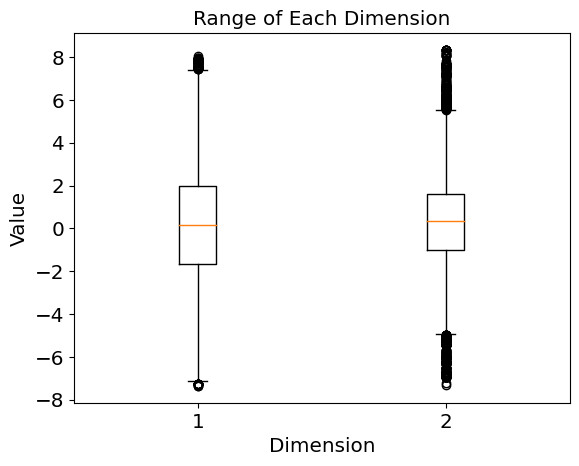

In [4]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pickle
import torch
import pandas
from VAE_model import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sys import exit
from torch.utils.data import Dataset, DataLoader

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')


# Data path
training_data = "training_data/20231008"

# Model path
model = "training_20231008_113339"

# Read data
with open("./{}/seq_msa_binary.pkl".format(training_data), 'rb') as file_handle:
    seq_msa_binary = pickle.load(file_handle)    
num_seq = seq_msa_binary.shape[0]
len_protein = seq_msa_binary.shape[1]
num_res_type = seq_msa_binary.shape[2]
seq_msa_binary = seq_msa_binary.reshape((num_seq, -1))
seq_msa_binary = seq_msa_binary.astype(np.float32)

with open("./{}/seq_weight.pkl".format(training_data), 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)

with open("./{}/keys_list.pkl".format(training_data), 'rb') as file_handle:
    seq_keys = pickle.load(file_handle)

batch_size = num_seq
data = MSA_Dataset(seq_msa_binary, seq_weight, seq_keys)
dataloader = DataLoader(data, batch_size = batch_size)
vae = VAE(num_aa_type = 21,
          dim_latent_vars = 2,
          dim_msa_vars = len_protein*num_res_type,
          encoder_num_hidden_units = [500, 100], 
          decoder_num_hidden_units = [100, 500])
# vae.cuda()
vae.load_state_dict(torch.load("./model/{}/vae_fold_0.model".format(model)))

# Transform the data to mu
mu_list = []
sigma_list = []
key_list = []
for idx, data in enumerate(dataloader):
    msa, weight, key = data
    with torch.no_grad():
        mu, sigma = vae.encoder(msa)
        # gpu to cpu to numpy
        mu_list.append(mu.cpu().data.numpy())
        sigma_list.append(sigma.cpu().data.numpy())
        # key is a tuple
        key_list = key_list + list(key)

mu = np.vstack(mu_list)
sigma = np.vstack(sigma_list)

with open("./model/{}/latent_space.pkl".format(model), 'wb') as file_handle:
    pickle.dump({'key': key_list, 'mu': mu, 'sigma': sigma}, file_handle)

# Create a box plot
plt.boxplot(mu)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Range of Each Dimension')
plt.show()

#### Figure 3c. Visualization of the 2D latent space of cyclases

Class II: 4750
Class I: 4210
Unclassified: 1567
Class IV: 850
Class III: 92


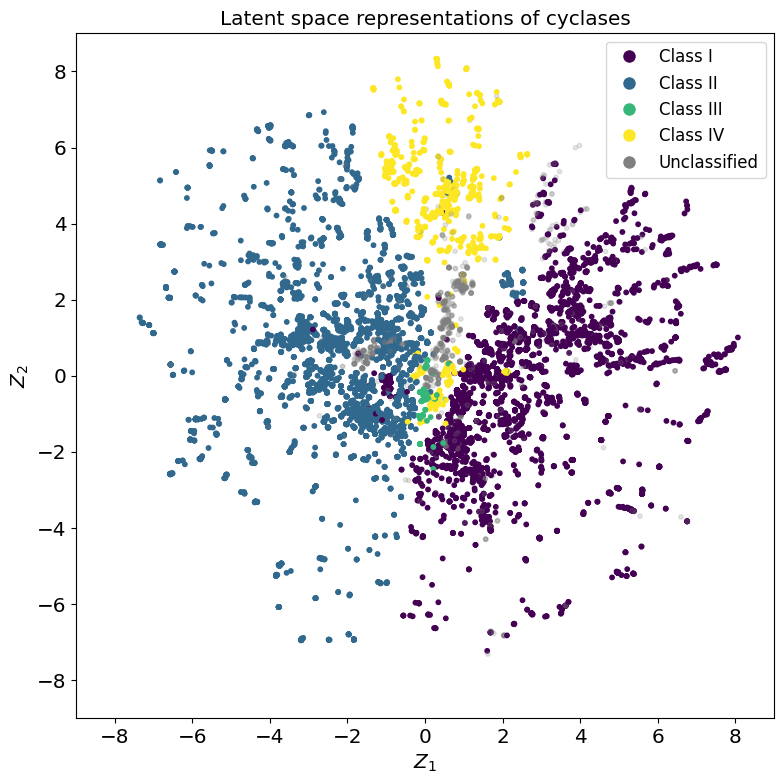

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from collections import Counter
from Bio import SeqIO
from matplotlib.lines import Line2D
from VAE_model import *

# Make the format of images consistent
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

# Model used
model = "training_20231008_113339"

# Read latent space representation
with open(f"./model/{model}/latent_space.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)

key = data['key']
mu = data['mu']

# Function to parse FASTA files
def parse_fasta(file_path):
    with open(file_path, "r") as handle:
        return ['WP_' + record.id.split('_')[1] for record in SeqIO.parse(handle, "fasta")]

# Function to read CSV and filter by class
def csv2class(file, class_no):
    df = pd.read_csv(file)
    filtered_df = df[df['Classification'] == class_no]
    unique_ids_list = filtered_df['Query'].unique().tolist()
    return unique_ids_list

# Combine FASTA and CSV results
def get_combined_ids():
    fasta_files = {
        'Class I': '../data/lanthipeptide/class_I-precursors_peptide.fasta',
        'Class II': '../data/lanthipeptide/class_II-precursors_peptide.fasta',
        'Class III': '../data/lanthipeptide/class_III-precursors_peptide.fasta',
        'Class IV': '../data/lanthipeptide/class_IV-precursors_peptide.fasta',
    }
    co_occur_file = '../data/RODEO_lanthipeptides/main_co_occur_all_classification_file.csv'

    class_I_ids = set(parse_fasta(fasta_files['Class I']) + csv2class(co_occur_file, 'class_I'))
    class_II_ids = set(parse_fasta(fasta_files['Class II']) + csv2class(co_occur_file, 'class_II'))
    class_III_ids = set(parse_fasta(fasta_files['Class III']) + csv2class(co_occur_file, 'class_III'))
    class_IV_ids = set(parse_fasta(fasta_files['Class IV']) + csv2class(co_occur_file, 'class_IV'))

    return class_I_ids, class_II_ids, class_III_ids, class_IV_ids

class_I_ids, class_II_ids, class_III_ids, class_IV_ids = get_combined_ids()

labels = []
unclassified_list = []
for k in key:
    k = k.split('/')[0]
    if k in class_I_ids:
        labels.append('Class I')
    elif k in class_II_ids:
        labels.append('Class II')
    elif k in class_III_ids:
        labels.append('Class III')
    elif k in class_IV_ids:
        labels.append('Class IV')
    else:
        labels.append('Unclassified')
        unclassified_list.append(k)

# Count the number of each class
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Creating a color map using plt's colormap
colormap = plt.cm.viridis  # choose any colormap that you like

# We exclude the first unique cluster (which should be 0) when generating colors
n_clusters = 4
n_colors = [colormap(i) for i in np.linspace(0, 1, n_clusters)]

color_map = {
    'Class I': n_colors[0],
    'Class II': n_colors[1],
    'Class III': n_colors[2],
    'Class IV': n_colors[3],
    'Unclassified': 'gray'
}

alpha_map = {
    'Class I': 1,
    'Class II': 1,
    'Class III': 1,
    'Class IV': 1,
    'Unclassified': 0.2
}

colors = [color_map[label] for label in labels]
alphas = [alpha_map[label] for label in labels]

plt.figure(figsize=(8, 8))
plt.scatter(mu[:, 0], mu[:, 1], c=colors, s=10, alpha=alphas)
plt.title('Latent space representations of cyclases')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.xlim((-9, 9))
plt.ylim((-9, 9))

# Hide the tick labels if needed
plt.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)

# Create a legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=value) for key, value in color_map.items()]
plt.legend(handles=legend_elements, loc='best')


# Save plot to file if needed
plt.tight_layout()
plt.savefig('PF05147_latent_space.png', dpi=300, format='png')
plt.show()


#### Figure 3e. Training classification models by using different embeddings

/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_2D, Classifier: Logistic Regression - Accuracy: 0.681 ± 0.023, F1-score: 0.607 ± 0.019, MCC: 0.662 ± 0.025


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_2D, Classifier: SVC - Accuracy: 0.715 ± 0.030, F1-score: 0.666 ± 0.028, MCC: 0.700 ± 0.032
Model: VAE_2D, Classifier: Naive Bayes - Accuracy: 0.889 ± 0.024, F1-score: 0.880 ± 0.025, MCC: 0.883 ± 0.025


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_2D, Classifier: KNN - Accuracy: 0.953 ± 0.012, F1-score: 0.948 ± 0.010, MCC: 0.950 ± 0.013
Model: VAE_2D, Classifier: Decision Tree - Accuracy: 0.948 ± 0.020, F1-score: 0.951 ± 0.015, MCC: 0.946 ± 0.019


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_2D, Classifier: Random Forest - Accuracy: 0.971 ± 0.014, F1-score: 0.969 ± 0.009, MCC: 0.971 ± 0.011


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_3D, Classifier: Logistic Regression - Accuracy: 0.778 ± 0.019, F1-score: 0.726 ± 0.019, MCC: 0.765 ± 0.020


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_3D, Classifier: SVC - Accuracy: 0.834 ± 0.009, F1-score: 0.803 ± 0.011, MCC: 0.825 ± 0.010
Model: VAE_3D, Classifier: Naive Bayes - Accuracy: 0.891 ± 0.018, F1-score: 0.882 ± 0.019, MCC: 0.885 ± 0.019


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_3D, Classifier: KNN - Accuracy: 0.943 ± 0.015, F1-score: 0.936 ± 0.015, MCC: 0.940 ± 0.016
Model: VAE_3D, Classifier: Decision Tree - Accuracy: 0.922 ± 0.014, F1-score: 0.921 ± 0.014, MCC: 0.920 ± 0.016


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_3D, Classifier: Random Forest - Accuracy: 0.954 ± 0.011, F1-score: 0.952 ± 0.011, MCC: 0.950 ± 0.008


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_5D, Classifier: Logistic Regression - Accuracy: 0.889 ± 0.018, F1-score: 0.859 ± 0.019, MCC: 0.883 ± 0.019


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_5D, Classifier: SVC - Accuracy: 0.910 ± 0.022, F1-score: 0.886 ± 0.026, MCC: 0.905 ± 0.023
Model: VAE_5D, Classifier: Naive Bayes - Accuracy: 0.920 ± 0.019, F1-score: 0.912 ± 0.018, MCC: 0.916 ± 0.020


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_5D, Classifier: KNN - Accuracy: 0.941 ± 0.012, F1-score: 0.933 ± 0.013, MCC: 0.937 ± 0.013
Model: VAE_5D, Classifier: Decision Tree - Accuracy: 0.892 ± 0.035, F1-score: 0.893 ± 0.022, MCC: 0.892 ± 0.028


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_5D, Classifier: Random Forest - Accuracy: 0.952 ± 0.014, F1-score: 0.945 ± 0.023, MCC: 0.941 ± 0.014


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: Logistic Regression - Accuracy: 0.966 ± 0.010, F1-score: 0.961 ± 0.011, MCC: 0.964 ± 0.011


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: SVC - Accuracy: 0.974 ± 0.011, F1-score: 0.967 ± 0.012, MCC: 0.972 ± 0.011
Model: VAE_10D, Classifier: Naive Bayes - Accuracy: 0.928 ± 0.031, F1-score: 0.914 ± 0.037, MCC: 0.924 ± 0.033


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_10D, Classifier: KNN - Accuracy: 0.954 ± 0.013, F1-score: 0.945 ± 0.011, MCC: 0.951 ± 0.014


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: Decision Tree - Accuracy: 0.886 ± 0.020, F1-score: 0.882 ± 0.029, MCC: 0.891 ± 0.028


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: Random Forest - Accuracy: 0.966 ± 0.016, F1-score: 0.967 ± 0.017, MCC: 0.969 ± 0.019


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Logistic Regression - Accuracy: 0.893 ± 0.008, F1-score: 0.859 ± 0.012, MCC: 0.887 ± 0.009


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: SVC - Accuracy: 0.189 ± 0.002, F1-score: 0.060 ± 0.001, MCC: 0.135 ± 0.002


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Naive Bayes - Accuracy: 0.878 ± 0.018, F1-score: 0.864 ± 0.020, MCC: 0.872 ± 0.019


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: KNN - Accuracy: 0.920 ± 0.017, F1-score: 0.910 ± 0.015, MCC: 0.916 ± 0.018


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Decision Tree - Accuracy: 0.795 ± 0.027, F1-score: 0.765 ± 0.024, MCC: 0.778 ± 0.031


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Random Forest - Accuracy: 0.946 ± 0.006, F1-score: 0.930 ± 0.012, MCC: 0.943 ± 0.009


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Logistic Regression - Accuracy: 0.692 ± 0.020, F1-score: 0.603 ± 0.019, MCC: 0.675 ± 0.022


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: SVC - Accuracy: 0.752 ± 0.021, F1-score: 0.688 ± 0.021, MCC: 0.740 ± 0.022


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Naive Bayes - Accuracy: 0.885 ± 0.014, F1-score: 0.872 ± 0.016, MCC: 0.880 ± 0.014


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: KNN - Accuracy: 0.929 ± 0.016, F1-score: 0.920 ± 0.016, MCC: 0.926 ± 0.017


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Decision Tree - Accuracy: 0.790 ± 0.033, F1-score: 0.783 ± 0.042, MCC: 0.786 ± 0.034


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Random Forest - Accuracy: 0.948 ± 0.008, F1-score: 0.940 ± 0.004, MCC: 0.943 ± 0.009


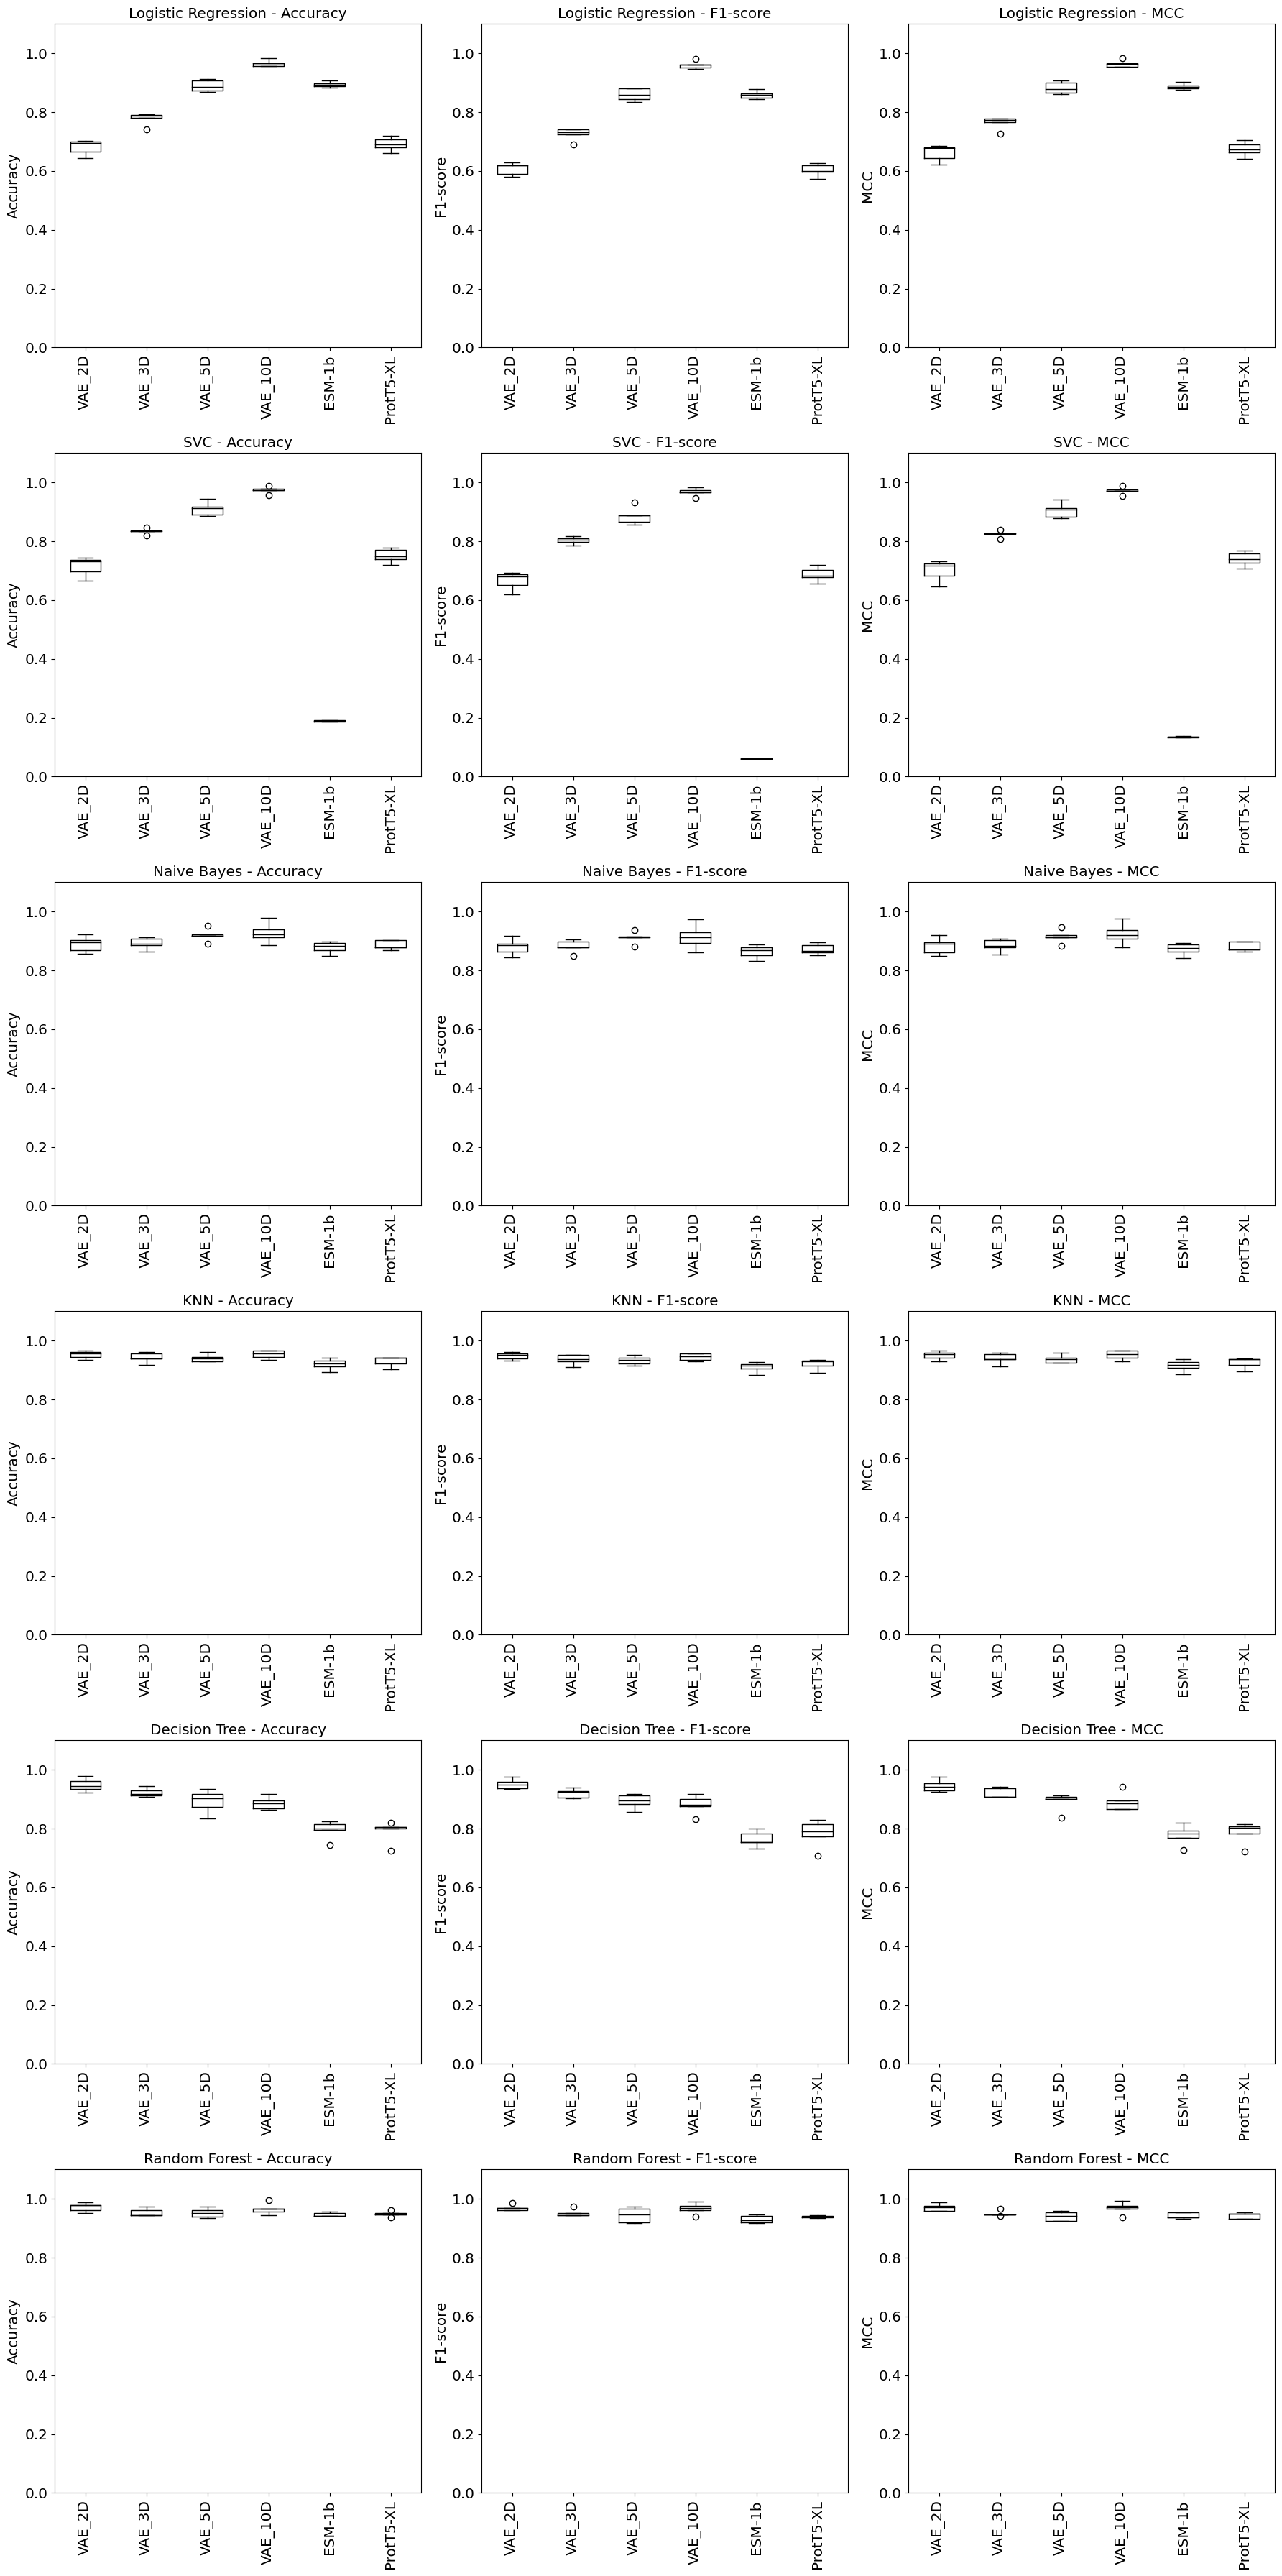

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import pandas as pd
import h5py
from Bio import SeqIO
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Make the format of images consistent
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

# VAE models with 2–10 dimensions, ProtT5-XL, and ESM-1b
model_dict = {
    'VAE_2D': "training_20231008_113339",
    'VAE_3D': "training_20240306_211407",
    'VAE_5D': "training_20240311_144749",
    'VAE_10D': "training_20240306_211653",
    'ProtT5-XL': "/home/cdchiang/ProtTrans/protein_embeddings.h5",
    'ESM-1b': "ESM1b_key2mu.pkl"
}

# Read latent space representation
def read_embeddings(model_name):
    model_path = model_dict[model_name]
    key2mu = {}
    if model_name.startswith("VAE"):
        with open(f"./model/{model_path}/latent_space.pkl", 'rb') as file_handle:
            data = pickle.load(file_handle)
        key = data['key']
        mu = data['mu']
        key2mu = {k.split('/')[0]: m for k, m in zip(key, mu)}
    elif model_name == "ProtT5-XL":
        with h5py.File(model_path, 'r') as h5_file:
            keys = list(h5_file.keys())
            for key in keys:
                data = h5_file[key][:]
                new_key = key[:14]
                parts = new_key.split('_', 2)
                if len(parts) == 3:
                    new_key = parts[0] + '_' + parts[1] + '.' + parts[2]
                key2mu[new_key] = data
    elif model_name == "ESM-1b":
        with open(f"./model/{model_path}", 'rb') as f:
            key2mu = pickle.load(f)
    return key2mu

# Read SSN
def read_ssn(ssn_file):
    df = pd.read_excel(ssn_file)
    id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Sequence Count Cluster Number']
    id_to_cluster_dict = {id: num for id, num in zip(id_list, cluster_list)}
    return id_to_cluster_dict

def data_prep(key2mu, data):
    common_keys = set(key2mu.keys()) & set(data.keys())
    X = [key2mu[k] for k in common_keys]
    y = [data[k] for k in common_keys]
    return np.array(X), np.array(y)

# SSN data
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_AS14_node_sorted.xlsx"
# ssn_file = "../data/ssn/csv_file/class_II-precursors_peptide_AS14_node_sorted.xlsx"
# ssn_file = "../data/ssn/csv_file/class_IV-precursors_peptide_AS14_node_sorted.xlsx"

# Read SSN
class_data = read_ssn(ssn_file)

# Classifiers to be trained
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "SVC": SVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

representation_models = ['VAE_2D', 'VAE_3D', 'VAE_5D', 'VAE_10D', 'ESM-1b', 'ProtT5-XL']

results = {model: {clf: {"Accuracy": [], "F1-score": [], "MCC": []} for clf in classifiers} for model in representation_models}

for model in representation_models:
    key2mu = read_embeddings(model)
    X, y = data_prep(key2mu, class_data)
    
    if X.size == 0 or y.size == 0:
        print(f"Skipping model {model} due to empty X or y.")
        continue
    
    for classifier_name, classifier in classifiers.items():
        accuracy_scores = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(classifier, X, y, cv=cv, scoring='f1_weighted')
        mcc_scorer = make_scorer(matthews_corrcoef)
        mcc_scores = cross_val_score(classifier, X, y, cv=cv, scoring=mcc_scorer)
        
        results[model][classifier_name]["Accuracy"] = accuracy_scores
        results[model][classifier_name]["F1-score"] = f1_scores
        results[model][classifier_name]["MCC"] = mcc_scores
        
        print(f"Model: {model}, Classifier: {classifier_name} - Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}, F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}, MCC: {np.mean(mcc_scores):.3f} ± {np.std(mcc_scores):.3f}")

# Plot boxplots for each metric
plt.figure(figsize=(18, 36))
yticks = np.arange(0, 1.2, 0.2)

for i, classifier_name in enumerate(classifiers.keys()):
    for j, metric_name in enumerate(["Accuracy", "F1-score", "MCC"]):
        plt.subplot(6, 3, i*3 + j + 1)
        data_to_plot = [results[model][classifier_name][metric_name] for model in representation_models]
        # plt.boxplot(data_to_plot, labels=representation_models)
        box = plt.boxplot(data_to_plot, labels=representation_models, patch_artist=False)
        for median in box['medians']:
            median.set(color='black')
        plt.title(f'{classifier_name} - {metric_name}')
        plt.xticks(rotation=90)
        plt.ylabel(metric_name)
        plt.yticks(yticks)
        plt.ylim(0, 1.1)

plt.tight_layout()
plt.savefig('Representation_Model_Comparison_ClassI.png', dpi=300, format='png')
plt.show()

# Save results to Excel file
results_summary = []

for model in representation_models:
    for classifier_name in classifiers.keys():
        accuracy_scores = results[model][classifier_name]["Accuracy"]
        f1_scores = results[model][classifier_name]["F1-score"]
        mcc_scores = results[model][classifier_name]["MCC"]
        
        results_summary.append({
            "Model": model,
            "Classifier": classifier_name,
            "Accuracy Mean": np.mean(accuracy_scores),
            "Accuracy Std": np.std(accuracy_scores),
            "F1-score Mean": np.mean(f1_scores),
            "F1-score Std": np.std(f1_scores),
            "MCC Mean": np.mean(mcc_scores),
            "MCC Std": np.std(mcc_scores)
        })

results_df = pd.DataFrame(results_summary)
results_df.to_excel("classification_results_summary_classI.xlsx", index=False)

#### Figure 3e. Training classification models by using different embeddings (version 2)

/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_2D, Classifier: Logistic Regression - Accuracy: 0.678 ± 0.033, F1-score: 0.606 ± 0.032, MCC: 0.658 ± 0.036


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_2D, Classifier: SVC - Accuracy: 0.720 ± 0.019, F1-score: 0.669 ± 0.019, MCC: 0.706 ± 0.021
Model: VAE_2D, Classifier: Naive Bayes - Accuracy: 0.893 ± 0.021, F1-score: 0.883 ± 0.020, MCC: 0.887 ± 0.022


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_2D, Classifier: KNN - Accuracy: 0.951 ± 0.010, F1-score: 0.947 ± 0.010, MCC: 0.948 ± 0.010
Model: VAE_2D, Classifier: Decision Tree - Accuracy: 0.956 ± 0.017, F1-score: 0.953 ± 0.014, MCC: 0.950 ± 0.017


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_2D, Classifier: Random Forest - Accuracy: 0.975 ± 0.007, F1-score: 0.969 ± 0.008, MCC: 0.972 ± 0.006


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_3D, Classifier: Logistic Regression - Accuracy: 0.783 ± 0.016, F1-score: 0.731 ± 0.014, MCC: 0.770 ± 0.017


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_3D, Classifier: SVC - Accuracy: 0.839 ± 0.003, F1-score: 0.805 ± 0.004, MCC: 0.829 ± 0.003
Model: VAE_3D, Classifier: Naive Bayes - Accuracy: 0.897 ± 0.014, F1-score: 0.888 ± 0.014, MCC: 0.891 ± 0.014


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_3D, Classifier: KNN - Accuracy: 0.944 ± 0.017, F1-score: 0.937 ± 0.019, MCC: 0.941 ± 0.018
Model: VAE_3D, Classifier: Decision Tree - Accuracy: 0.915 ± 0.018, F1-score: 0.918 ± 0.018, MCC: 0.914 ± 0.015


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_3D, Classifier: Random Forest - Accuracy: 0.955 ± 0.011, F1-score: 0.949 ± 0.014, MCC: 0.952 ± 0.011


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_5D, Classifier: Logistic Regression - Accuracy: 0.888 ± 0.007, F1-score: 0.859 ± 0.007, MCC: 0.882 ± 0.007


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_5D, Classifier: SVC - Accuracy: 0.916 ± 0.010, F1-score: 0.893 ± 0.012, MCC: 0.911 ± 0.010
Model: VAE_5D, Classifier: Naive Bayes - Accuracy: 0.916 ± 0.025, F1-score: 0.904 ± 0.030, MCC: 0.911 ± 0.027


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_5D, Classifier: KNN - Accuracy: 0.945 ± 0.012, F1-score: 0.937 ± 0.015, MCC: 0.942 ± 0.013
Model: VAE_5D, Classifier: Decision Tree - Accuracy: 0.895 ± 0.018, F1-score: 0.882 ± 0.018, MCC: 0.893 ± 0.020


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_5D, Classifier: Random Forest - Accuracy: 0.957 ± 0.019, F1-score: 0.947 ± 0.020, MCC: 0.948 ± 0.019


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: Logistic Regression - Accuracy: 0.965 ± 0.012, F1-score: 0.961 ± 0.014, MCC: 0.963 ± 0.012


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: SVC - Accuracy: 0.972 ± 0.013, F1-score: 0.964 ± 0.016, MCC: 0.970 ± 0.013
Model: VAE_10D, Classifier: Naive Bayes - Accuracy: 0.923 ± 0.012, F1-score: 0.912 ± 0.013, MCC: 0.919 ± 0.013


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in 

Model: VAE_10D, Classifier: KNN - Accuracy: 0.962 ± 0.012, F1-score: 0.954 ± 0.016, MCC: 0.959 ± 0.013


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: Decision Tree - Accuracy: 0.871 ± 0.012, F1-score: 0.869 ± 0.017, MCC: 0.864 ± 0.020


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: VAE_10D, Classifier: Random Forest - Accuracy: 0.966 ± 0.009, F1-score: 0.964 ± 0.015, MCC: 0.964 ± 0.013


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Logistic Regression - Accuracy: 0.890 ± 0.015, F1-score: 0.857 ± 0.015, MCC: 0.884 ± 0.015


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: SVC - Accuracy: 0.189 ± 0.003, F1-score: 0.060 ± 0.002, MCC: 0.135 ± 0.002


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Naive Bayes - Accuracy: 0.872 ± 0.022, F1-score: 0.856 ± 0.024, MCC: 0.866 ± 0.023


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: KNN - Accuracy: 0.920 ± 0.010, F1-score: 0.910 ± 0.010, MCC: 0.916 ± 0.011


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Decision Tree - Accuracy: 0.788 ± 0.015, F1-score: 0.795 ± 0.022, MCC: 0.774 ± 0.024


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ESM-1b, Classifier: Random Forest - Accuracy: 0.935 ± 0.016, F1-score: 0.936 ± 0.011, MCC: 0.941 ± 0.014


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Logistic Regression - Accuracy: 0.687 ± 0.018, F1-score: 0.598 ± 0.019, MCC: 0.669 ± 0.019


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: SVC - Accuracy: 0.749 ± 0.024, F1-score: 0.685 ± 0.024, MCC: 0.737 ± 0.026


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Naive Bayes - Accuracy: 0.882 ± 0.026, F1-score: 0.867 ± 0.029, MCC: 0.876 ± 0.028


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: KNN - Accuracy: 0.931 ± 0.016, F1-score: 0.921 ± 0.017, MCC: 0.928 ± 0.017


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Decision Tree - Accuracy: 0.793 ± 0.027, F1-score: 0.788 ± 0.018, MCC: 0.781 ± 0.022


/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/cdchiang/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model: ProtT5-XL, Classifier: Random Forest - Accuracy: 0.943 ± 0.011, F1-score: 0.934 ± 0.015, MCC: 0.941 ± 0.014


/tmp/ipykernel_1546109/621909237.py:141: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


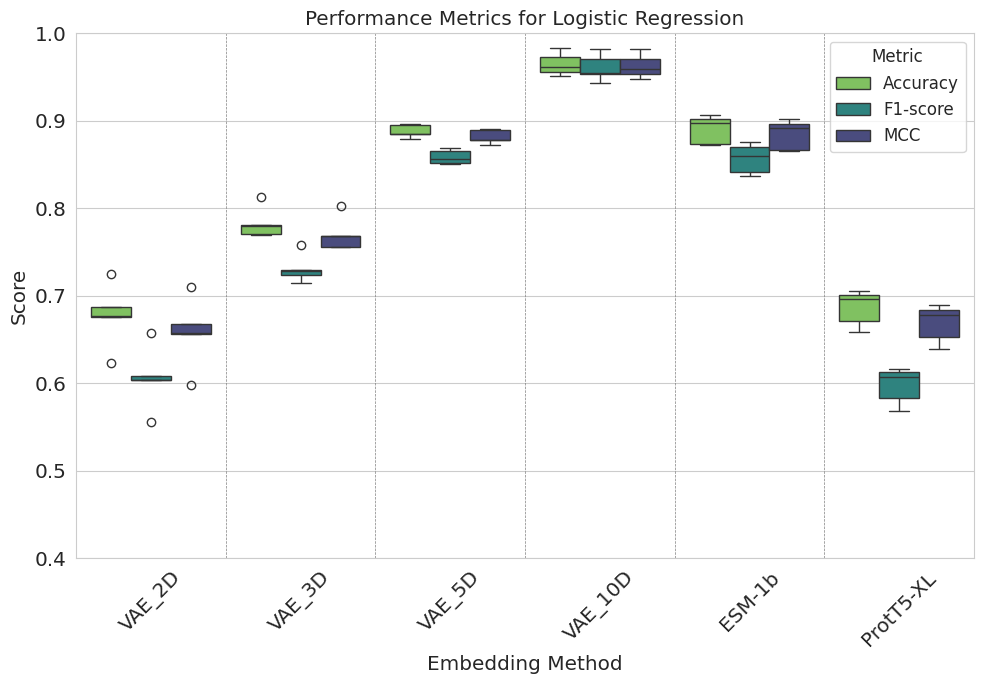

Figure saved as Results_Logistic_Regression_20241226.png


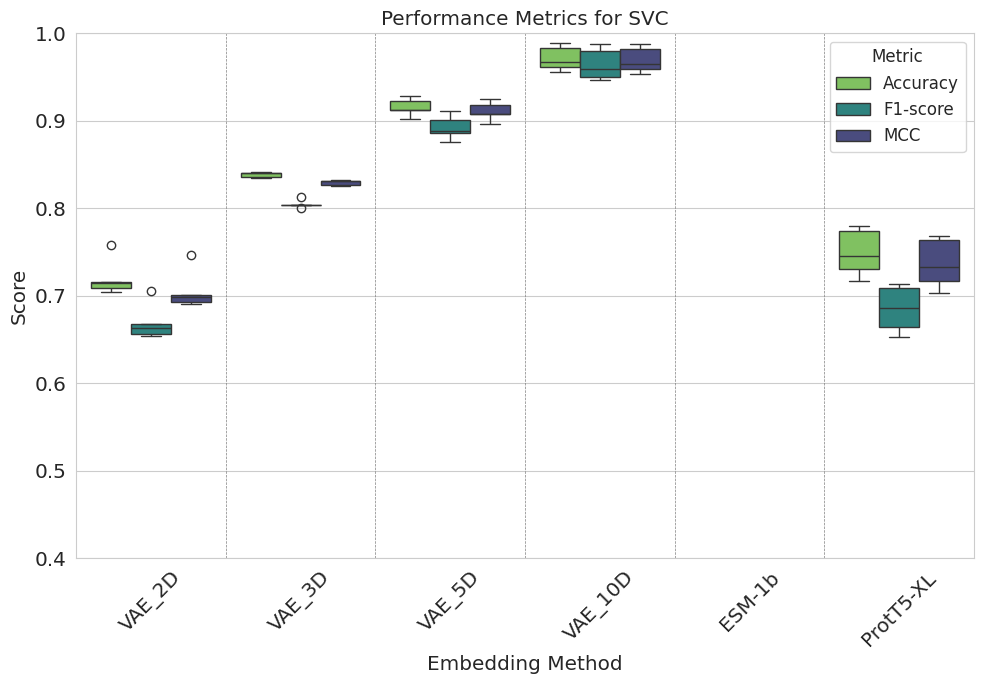

Figure saved as Results_SVC_20241226.png


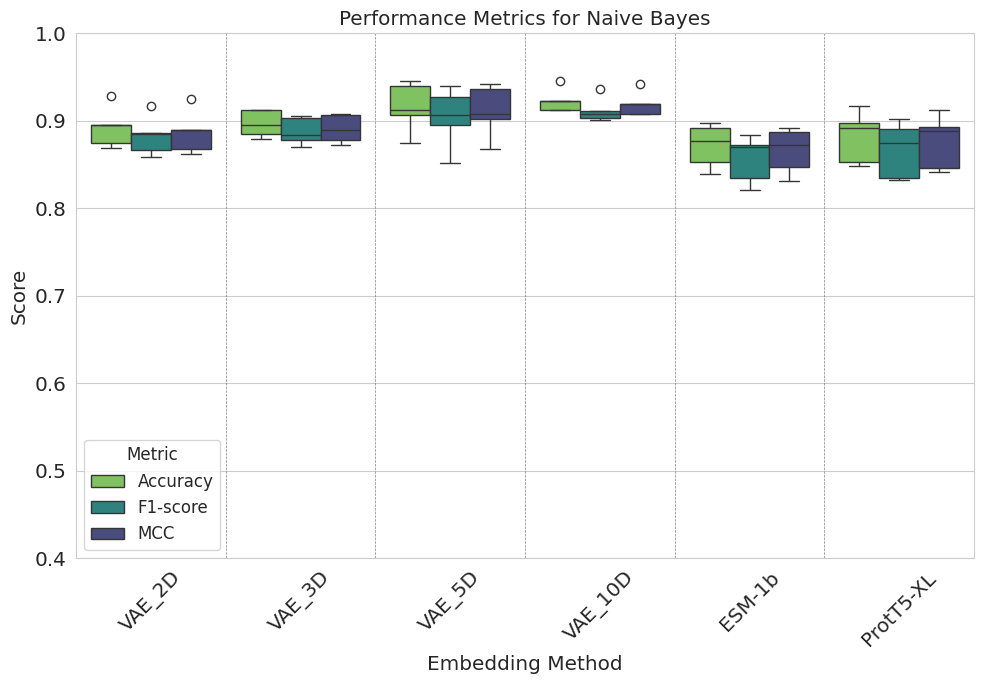

Figure saved as Results_Naive_Bayes_20241226.png


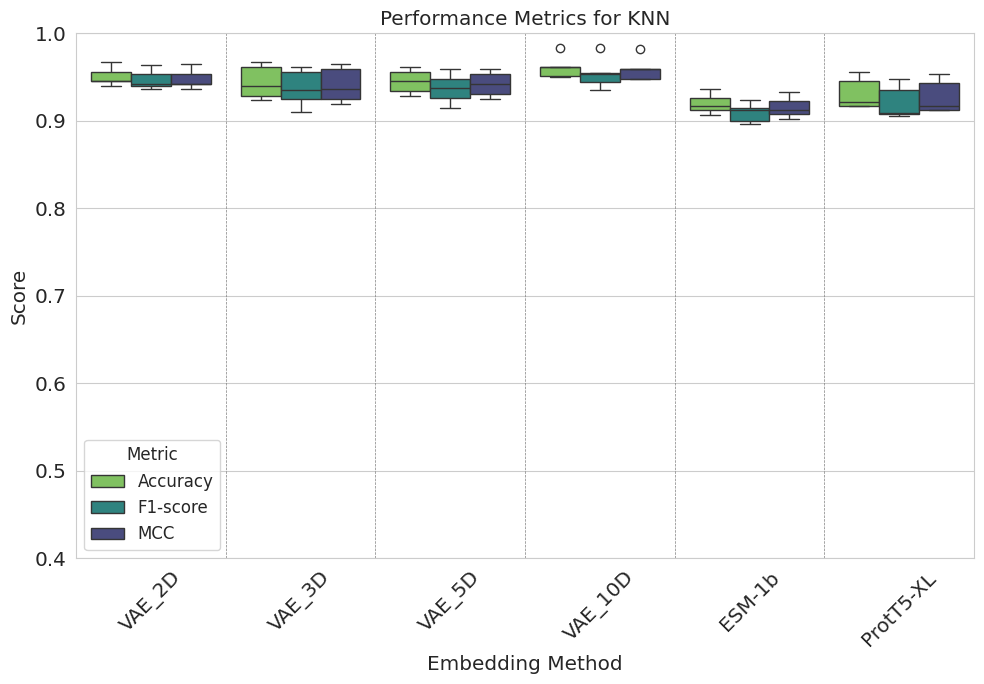

Figure saved as Results_KNN_20241226.png


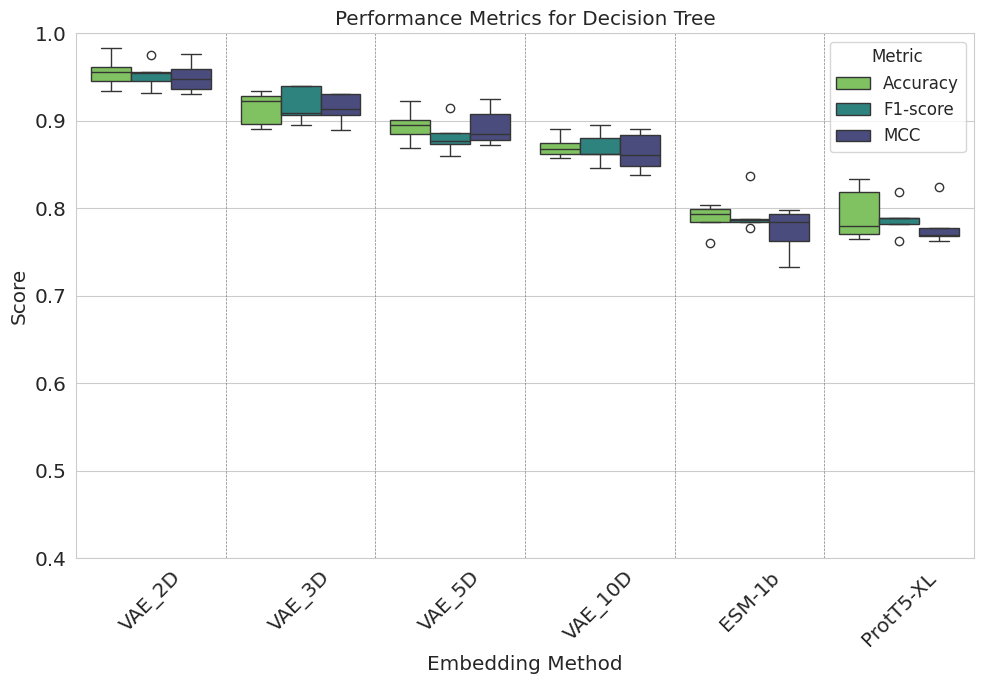

Figure saved as Results_Decision_Tree_20241226.png


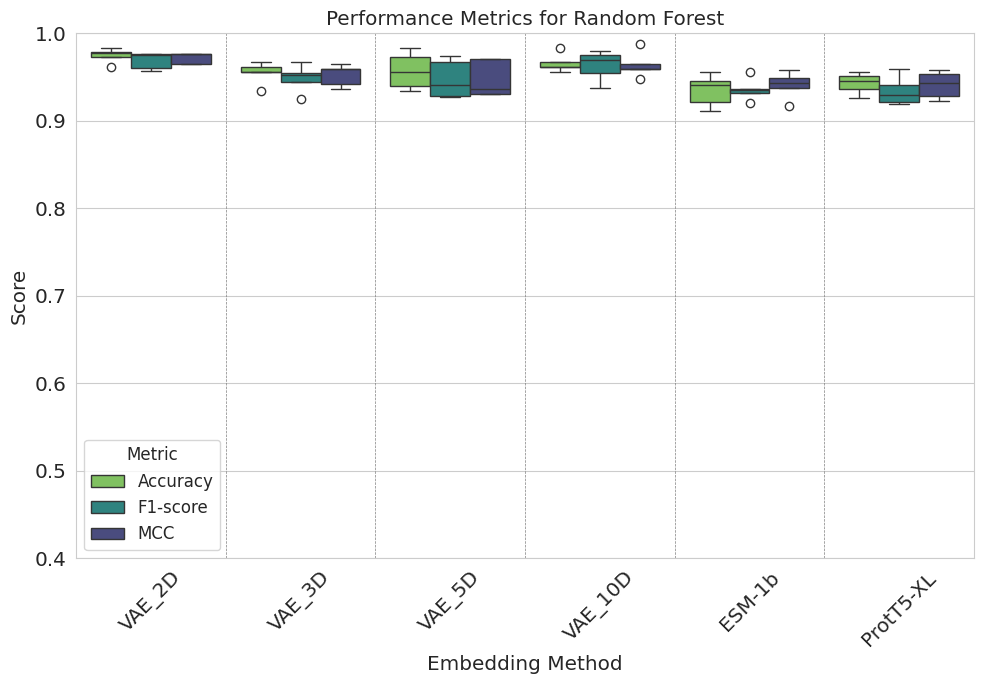

Figure saved as Results_Random_Forest_20241226.png
Results saved to classification_results_summary.xlsx.


In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import pandas as pd
import h5py
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import matthews_corrcoef, make_scorer
import matplotlib.cm as cm  # Import for colormap

# Make the format of images consistent
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

# VAE models and ProtT5-XL
model_dict = {
    'VAE_2D': "training_20231008_113339",
    'VAE_3D': "training_20240306_211407",
    'VAE_5D': "training_20240311_144749",
    'VAE_10D': "training_20240306_211653",
    'ProtT5-XL': "/home/cdchiang/ProtTrans/protein_embeddings.h5",
    'ESM-1b': "ESM1b_key2mu.pkl"
}

# Read latent space representation
def read_embeddings(model_name):
    model_path = model_dict[model_name]
    key2mu = {}
    if model_name.startswith("VAE"):
        with open(f"./model/{model_path}/latent_space.pkl", 'rb') as file_handle:
            data = pickle.load(file_handle)
        key = data['key']
        mu = data['mu']
        key2mu = {k.split('/')[0]: m for k, m in zip(key, mu)}
    elif model_name == "ProtT5-XL":
        with h5py.File(model_path, 'r') as h5_file:
            keys = list(h5_file.keys())
            for key in keys:
                data = h5_file[key][:]
                new_key = key[:14]
                parts = new_key.split('_', 2)
                if len(parts) == 3:
                    new_key = parts[0] + '_' + parts[1] + '.' + parts[2]
                key2mu[new_key] = data
    elif model_name == "ESM-1b":
        with open(f"./model/{model_path}", 'rb') as f:
            key2mu = pickle.load(f)
    return key2mu

# Read SSN
def read_ssn(ssn_file):
    df = pd.read_excel(ssn_file)
    id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Sequence Count Cluster Number']
    id_to_cluster_dict = {id: num for id, num in zip(id_list, cluster_list)}
    return id_to_cluster_dict

def data_prep(key2mu, data):
    common_keys = set(key2mu.keys()) & set(data.keys())
    X = [key2mu[k] for k in common_keys]
    y = [data[k] for k in common_keys]
    return np.array(X), np.array(y)

# SSN data
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_AS14_node_sorted.xlsx"
# ssn_file = "../data/ssn/csv_file/class_II-precursors_peptide_AS14_node_sorted.xlsx"
# ssn_file = "../data/ssn/csv_file/class_IV-precursors_peptide_AS14_node_sorted.xlsx"

# Read SSN
class_data = read_ssn(ssn_file)

# Classifiers to be trained
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "SVC": SVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

representation_models = ['VAE_2D', 'VAE_3D', 'VAE_5D', 'VAE_10D', 'ESM-1b', 'ProtT5-XL']

# Initialize a list to collect all results
all_results = []

for model in representation_models:
    key2mu = read_embeddings(model)
    X, y = data_prep(key2mu, class_data)
    
    if X.size == 0 or y.size == 0:
        print(f"Skipping model {model} due to empty X or y.")
        continue
    
    for classifier_name, classifier in classifiers.items():
        accuracy_scores = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(classifier, X, y, cv=cv, scoring='f1_weighted')
        mcc_scorer = make_scorer(matthews_corrcoef)
        mcc_scores = cross_val_score(classifier, X, y, cv=cv, scoring=mcc_scorer)
        
        # Collect results for plotting
        for fold_idx in range(len(accuracy_scores)):
            all_results.append({
                "Classifier": classifier_name,
                "Embedding": model,
                "Metric": "Accuracy",
                "Score": accuracy_scores[fold_idx]
            })
            all_results.append({
                "Classifier": classifier_name,
                "Embedding": model,
                "Metric": "F1-score",
                "Score": f1_scores[fold_idx]
            })
            all_results.append({
                "Classifier": classifier_name,
                "Embedding": model,
                "Metric": "MCC",
                "Score": mcc_scores[fold_idx]
            })
        
        print(f"Model: {model}, Classifier: {classifier_name} - Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}, F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}, MCC: {np.mean(mcc_scores):.3f} ± {np.std(mcc_scores):.3f}")

# Convert all_results to a DataFrame
results_df = pd.DataFrame(all_results)

# Create a custom color palette using the viridis colormap
# We select positions in the colormap to get greenish to purplish colors
viridis = cm.get_cmap('viridis')
colors = [viridis(x) for x in [0.8, 0.5, 0.2]]  # Positions correspond to greenish to purplish
metrics = ['Accuracy', 'F1-score', 'MCC']
palette = dict(zip(metrics, colors))

# Plotting
for classifier_name in classifiers.keys():
    plt.figure(figsize=(10, 7))
    sns.set_style("whitegrid")
    # Filter results for the current classifier
    clf_results = results_df[results_df["Classifier"] == classifier_name]
    # Create a boxplot with the custom palette
    sns.boxplot(
        data=clf_results,
        x="Embedding",
        y="Score",
        hue="Metric",
        palette=palette
    )
    plt.title(f'Performance Metrics for {classifier_name}')
    plt.xlabel('Embedding Method')
    plt.ylabel('Score')
    plt.ylim(0.4, 1.0)
    # plt.legend(title='Metric')
    plt.xticks(rotation=45)
    
    # Draw vertical lines to separate each embedding method
    num_embeddings = len(representation_models)
    for i in range(1, num_embeddings):
        plt.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    # Save the figure
    filename = f'Results_{classifier_name.replace(" ", "_")}_20241226.png'
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

# Save results to Excel file
# Create a summary DataFrame
summary_rows = []
for (model, classifier_name), group in results_df.groupby(["Embedding", "Classifier"]):
    for metric_name in ["Accuracy", "F1-score", "MCC"]:
        metric_scores = group[group["Metric"] == metric_name]["Score"]
        summary_rows.append({
            "Model": model,
            "Classifier": classifier_name,
            "Metric": metric_name,
            "Mean Score": metric_scores.mean(),
            "Std Score": metric_scores.std()
        })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_excel("classification_results_summary_20241226.xlsx", index=False)
print("Results saved to classification_results_summary.xlsx.")



#### Figure 3f. Clustering agreement evaluated by adjusted mutual information (AMI) between:
(1) Clustering of **RiPPs peptide precursors by SSN**
(2) Clustering of **LanC-like cyclases in the 2D latent space** 

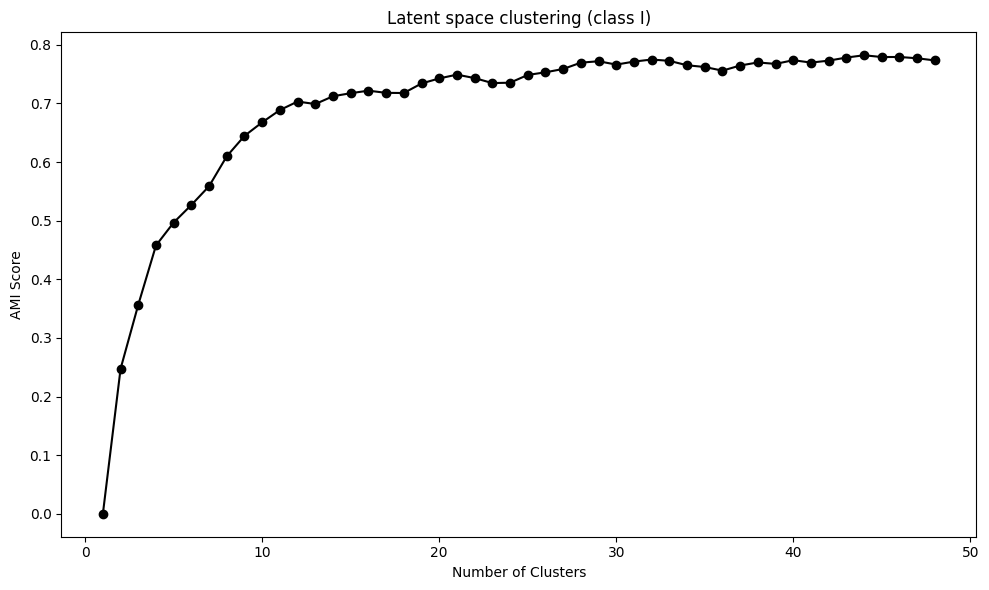

Highest AMI score from the latent space clustering:  0.7823013233178627
SSN_AS46_Cluster_No:  8
SSN_AS46 AMI score:  0.3053446080109746
SSN_AS52_Cluster_No:  13
SSN_AS52 AMI score:  0.3311858382228783
SSN_AS66_Cluster_No:  28
SSN_AS66 AMI score:  0.6914732228726799
SSN_AS80_Cluster_No:  38
SSN_AS80 AMI score:  0.7682558762652643


In [5]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from Bio import SeqIO
from VAE_model import *
from sys import exit
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Make the format of images consistent

mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')

# Read latent space representation

model = "training_20231008_113339" # model directory
with open("./model/{}/latent_space.pkl".format(model), 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
key2mu = {k[0:14]: m for k, m in zip(key, mu)}

# Read the SSN clustering of cyclases (alignment score: 46)

enzyme_ssn_file_AS46 = "/home/cdchiang/vae/RiPPs/data/ssn/csv_file/PF05147_hits_200_500aa_latentspace_AS46 Full Network colorized default node.csv"
df_enzyme_46 = pd.read_csv(enzyme_ssn_file_AS46)
enzyme_id_list_46 = df_enzyme_46['name'].apply(lambda x: x[0:14]).tolist()
enzyme_cluster_list_46 = df_enzyme_46['Node Count Cluster Number']
key2ssn_46 = {id: cluster_no for id, cluster_no in zip(enzyme_id_list_46, enzyme_cluster_list_46)}

# Read the SSN clustering of cyclases (alignment score: 52)

enzyme_ssn_file_AS52 = "/home/cdchiang/vae/RiPPs/data/ssn/csv_file/PF05147_hits_200_500aa_latentspace_AS52 Full Network colorized default node.csv"
df_enzyme_52 = pd.read_csv(enzyme_ssn_file_AS52)
enzyme_id_list_52 = df_enzyme_52['name'].apply(lambda x: x[0:14]).tolist()
enzyme_cluster_list_52 = df_enzyme_52['Node Count Cluster Number']
key2ssn_52 = {id: cluster_no for id, cluster_no in zip(enzyme_id_list_52, enzyme_cluster_list_52)}

# Read the SSN clustering of cyclases (alignment score: 66)

enzyme_ssn_file_AS66 = "/home/cdchiang/vae/RiPPs/data/ssn/csv_file/PF05147_hits_200_500aa_latentspace_AS66 Full Network colorized default node.csv"
df_enzyme_66 = pd.read_csv(enzyme_ssn_file_AS66)
enzyme_id_list_66 = df_enzyme_66['name'].apply(lambda x: x[0:14]).tolist()
enzyme_cluster_list_66 = df_enzyme_66['Node Count Cluster Number']
key2ssn_66 = {id: cluster_no for id, cluster_no in zip(enzyme_id_list_66, enzyme_cluster_list_66)}

# Read the SSN clustering of cyclases (alignment score: 80)

enzyme_ssn_file_AS80 = "/home/cdchiang/vae/RiPPs/data/ssn/csv_file/PF05147_hits_200_500aa_latentspace_AS80 Full Network colorized default node.csv"
df_enzyme_80 = pd.read_csv(enzyme_ssn_file_AS80)
enzyme_id_list_80 = df_enzyme_80['name'].apply(lambda x: x[0:14]).tolist()
enzyme_cluster_list_80 = df_enzyme_80['Node Count Cluster Number']
key2ssn_80 = {id: cluster_no for id, cluster_no in zip(enzyme_id_list_80, enzyme_cluster_list_80)}

# Read the SSN clustering of lanthipeptide precursors

def ssn_analyzer(file):

    df = pd.read_excel(file)
    # id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    id_list = df['Description'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Node Count Cluster Number']
    id_to_cluster_dict = {id: cluster_no for id, cluster_no in zip(id_list, cluster_list)}

    return id_to_cluster_dict

# SSN files of the lanthipeptide precursors (I, II, and IV)
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_AS14_node_sorted.xlsx"
# ssn_file = "../data/ssn/csv_file/class_II-precursors_peptide_AS14_node_sorted.xlsx"
# ssn_file = "../data/ssn/csv_file/class_IV-precursors_peptide_AS14_node_sorted.xlsx"

id_to_cluster_dict = ssn_analyzer(ssn_file)

labels_true = []
ssn_label_46 = []
ssn_label_52 = []
ssn_label_66 = []
ssn_label_80 = []
mu_values = []
for id in id_to_cluster_dict.keys():
    if id in key2ssn_46 and id in key2ssn_52 and key2ssn_66 and key2ssn_80 and id in key2mu:
        if not math.isnan(key2ssn_46[id]) and not math.isnan(key2ssn_52[id]) and not math.isnan(key2ssn_66[id]) and not math.isnan(key2ssn_80[id]):
            labels_true.append(id_to_cluster_dict[id])
            ssn_label_46.append(key2ssn_46[id])
            ssn_label_52.append(key2ssn_52[id])
            ssn_label_66.append(key2ssn_66[id])
            ssn_label_80.append(key2ssn_80[id])
            mu_values.append(key2mu[id])

# Convert the list of mu values to a NumPy array
mu_array = np.array(mu_values)

# Adjusted mutual information (AMI) calculation
AMI_score = []
unique_clusters = len(set(id_to_cluster_dict.values()))
for n in range(1, unique_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n).fit(mu_array)
    ami = adjusted_mutual_info_score(labels_true, clustering.labels_)
    AMI_score.append(ami)

# Create a DataFrame with the results
df = pd.DataFrame({
    "Number of clusters": list(range(1, unique_clusters + 1)),
    "AMI scores": AMI_score
})

# Save the DataFrame to an Excel file
df.to_excel("AMI_scores_latentspace_clustering_classI.xlsx", index=False)

# Plotting
num_clusters_list = [n for n in range(1, unique_clusters + 1)]

# Setting a white background for the plot
plt.style.use('default')
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(num_clusters_list, AMI_score, marker='o', color='black')
plt.xlabel('Number of Clusters')
plt.ylabel('AMI Score')
plt.title('Latent space clustering (class I)')
plt.tight_layout()
plt.savefig('AMI_latentspace_clustering_classI.png', dpi=300, format='png')
plt.show()

# Print
print('Highest AMI score from the latent space clustering: ', max(AMI_score))
print('SSN_AS46_Cluster_No: ', len(set(ssn_label_46)))
print('SSN_AS46 AMI score: ', adjusted_mutual_info_score(labels_true, ssn_label_46))
print('SSN_AS52_Cluster_No: ', len(set(ssn_label_52)))
print('SSN_AS52 AMI score: ', adjusted_mutual_info_score(labels_true, ssn_label_52))
print('SSN_AS66_Cluster_No: ', len(set(ssn_label_66)))
print('SSN_AS66 AMI score: ', adjusted_mutual_info_score(labels_true, ssn_label_66))
print('SSN_AS80_Cluster_No: ', len(set(ssn_label_80)))
print('SSN_AS80 AMI score: ', adjusted_mutual_info_score(labels_true, ssn_label_80))


#### Figure 3g. Navigate the function space (peptide substrate cluster distribution)

/tmp/ipykernel_2716853/3857660107.py:155: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


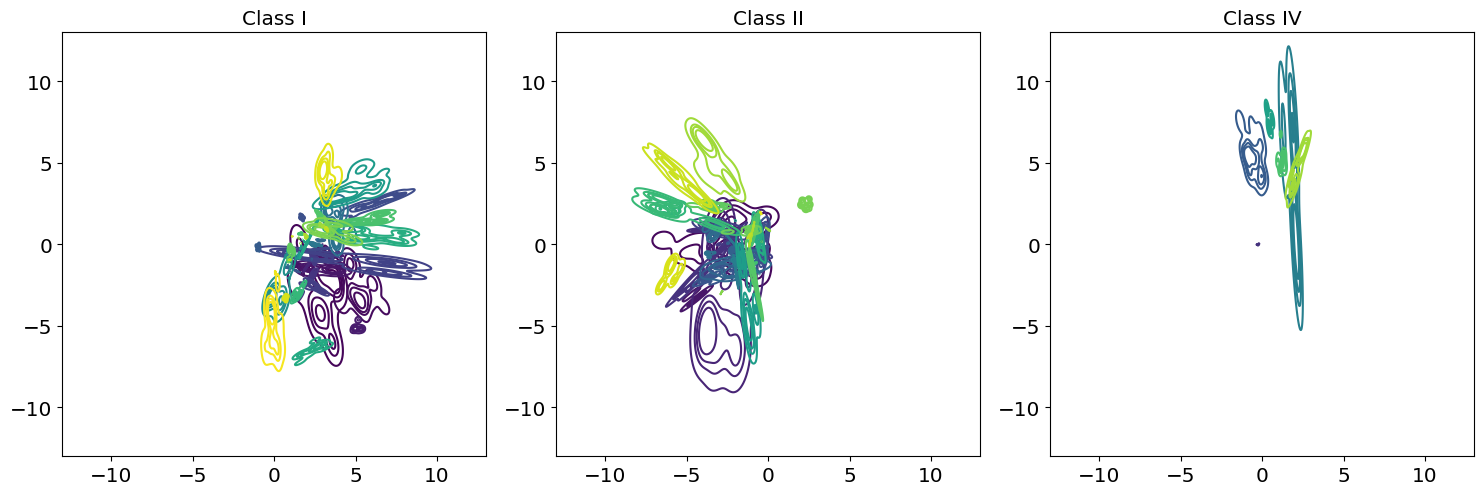

In [3]:
import matplotlib as mpl
# Non-interactive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torch.autograd import Variable
import numpy as np
import pickle
import torch
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from VAE_model import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sys import exit
from torch.utils.data import Dataset, DataLoader

# Make the format of images consistent
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

model = "training_20231008_113339"

# Read latent space representation
with open(f"./model/{model}/latent_space.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']

# Read FASTA file
def parse_fasta(file_path):
    with open(file_path, "r") as handle:
        return ['WP_' + record.id.split('_')[1] for record in SeqIO.parse(handle, "fasta")]

# Data from the paper
class_I_ids = parse_fasta('../data/lanthipeptide/class_I-precursors_peptide.fasta')
class_II_ids = parse_fasta('../data/lanthipeptide/class_II-precursors_peptide.fasta')
class_III_ids = parse_fasta('../data/lanthipeptide/class_III-precursors_peptide.fasta')
class_IV_ids = parse_fasta('../data/lanthipeptide/class_IV-precursors_peptide.fasta')

# Read CSV as a DataFrame
def csv2class(file, class_no):
    df = pd.read_csv(file)
    filtered_df = df[df['Classification'] == class_no]
    unique_ids_list = filtered_df['Query'].unique().tolist()
    return unique_ids_list

# Data from the RODEO prediction
co_occur_file = '../data/RODEO_lanthipeptides/main_co_occur_all_classification_file.csv'
class_I_ids_u = csv2class(co_occur_file, 'class_I')
class_II_ids_u = csv2class(co_occur_file, 'class_II')
class_III_ids_u = csv2class(co_occur_file, 'class_III')
class_IV_ids_u = csv2class(co_occur_file, 'class_IV')

# Assign classes to IDs
id2class = {}
for k in key:
    k = k.split('/')[0]
    if k in class_I_ids or k in class_I_ids_u:
        id2class[k] = 1
    elif k in class_II_ids or k in class_II_ids_u:
        id2class[k] = 2
    elif k in class_III_ids or k in class_III_ids_u:
        id2class[k] = 3
    elif k in class_IV_ids or k in class_IV_ids_u:
        id2class[k] = 4
    else:
        id2class[k] = 0

excel_file = '/home/cdchiang/vae/RiPPs/data/12864_2020_6785_MOESM2_ESM.xlsx'
excel_file2 = '/home/cdchiang/vae/RiPPs/data/RODEO_lanthipeptides/main_co_occur_all_classification_file.csv'

sheet_names = ['class_I-precursors', 'class_II-precursors', 'class_III-precursors', 'class_IV-precursors']

# Combine data from different sheets into id2genus
id2genus = {}
for sheet_name in sheet_names:
    try:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
        df['genus/species'] = df['genus/species'].apply(lambda x: x.split(' ')[0])
        df['Precursor SSN ID'] = df['Precursor SSN ID'].apply(lambda x: x[:14])
        id2genus.update(df.set_index('Precursor SSN ID')['genus/species'].to_dict())
    except Exception as e:
        print(f"Error reading sheet {sheet_name}: {e}")

# Read another CSV file and combine its data
try:
    df2 = pd.read_csv(excel_file2)
    df2_unique = df2.drop_duplicates(subset='Query').copy()
    df2_unique['Genus/Species'] = df2_unique['Genus/Species'].apply(lambda x: x.split(' ')[0])
    id2genus.update(df2_unique.set_index('Query')['Genus/Species'].to_dict())
except Exception as e:
    print(f"Error reading file: {e}")

# Load the genus_to_phylum dictionary from the file
with open('/home/cdchiang/vae/RiPPs/data/genus_to_phylum.pkl', 'rb') as f:
    genus_to_phylum = pickle.load(f)

# Map phylum to each enzyme ID
id2phylum = {enzyme_id: genus_to_phylum.get(genus, "Unknown") for enzyme_id, genus in id2genus.items()}

# Load the lanthipeptide data and the clustering info
id2peptide = {}
id2peptide_cluster = {}
for i in ["I", "II", "III", "IV"]:
    df3 = pd.read_excel(f"../data/ssn/csv_file/class_{i}-precursors_peptide_c_u_AS14 Full Network colorized default node_sorted_unique.xlsx")
    df3['Node Count Cluster Number'] = i + '-' + df3['Node Count Cluster Number'].astype(str)
    df3['name'] = df3['name'].str.slice(0, 14)
    id2peptide.update(df3.set_index('name')['Sequence'].to_dict())
    id2peptide_cluster.update(df3.set_index('name')['Node Count Cluster Number'].to_dict())

latent_space_data = {
    'Cyclase_id': [n[:14] for n in key],
    'Z1': mu[:, 0],
    'Z2': mu[:, 1],
    'Class': [id2class[n[:14]] for n in key]
}

df_latent_space = pd.DataFrame(latent_space_data)

# Map phylum to each enzyme ID in the DataFrame
df_latent_space['Phylum'] = df_latent_space['Cyclase_id'].map(id2phylum)

# Map peptide sequence and cluster number to each enzyme ID in the DataFrame
df_latent_space['Peptide'] = df_latent_space['Cyclase_id'].map(lambda x: id2peptide.get(x, 'Unknown'))
df_latent_space['Cluster No'] = df_latent_space['Cyclase_id'].map(lambda x: id2peptide_cluster.get(x, 'Unknown'))

df_latent_space.to_excel('./lanthipeptide_cyclase_latentspace_summary.xlsx', sheet_name='sheet1')

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Define big clusters to include only I, II, and IV
big_clusters = ['I', 'II', 'IV']
class_mapping = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}

# Iterate over big clusters and subplots
for i, big_cluster in enumerate(big_clusters):
    ax = axs[i]
    class_number = class_mapping[big_cluster]
    big_cluster_df = df_latent_space[
        (df_latent_space['Class'] == class_number) & (df_latent_space['Peptide'] != 'Unknown')
    ]
    small_clusters = big_cluster_df['Cluster No'].unique()

    # Define a color palette with enough colors for all small clusters
    palette = sns.color_palette("viridis", len(small_clusters))

    # Iterate over small clusters within each big cluster
    for j, small_cluster in enumerate(small_clusters):
        small_cluster_df = big_cluster_df[big_cluster_df['Cluster No'] == small_cluster]
        sns.kdeplot(
            x=small_cluster_df['Z1'],
            y=small_cluster_df['Z2'],
            levels=5,
            ax=ax,
            label=small_cluster,
            color=palette[j],
            legend=False
        )

    ax.set_title(f'Class {big_cluster}')
    # Hide x and y labels but keep ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(
        axis='both',
        which='both',
        bottom=True,
        top=False,
        left=True,
        right=False,
        labelbottom=True,
        labelleft=True
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-13, 13)
    ax.set_ylim(-13, 13)

plt.tight_layout()
plt.savefig('peptide_substrate_cluster_distribution.png', dpi= 300, format='png')
plt.show()



#### 3-dimensional latent space:

* Training run at 20240306_211407
* epochs: 1000
* weight_decay: 0.0007883056836832361
* batch_size: 128
* learning_rate: 0.0018419662384403465
* dim: 3
* encode_layer: [500, 100]
* decode_layer: [100, 500]
* seed: 2
* input_file_folder: ./training_data/20231008


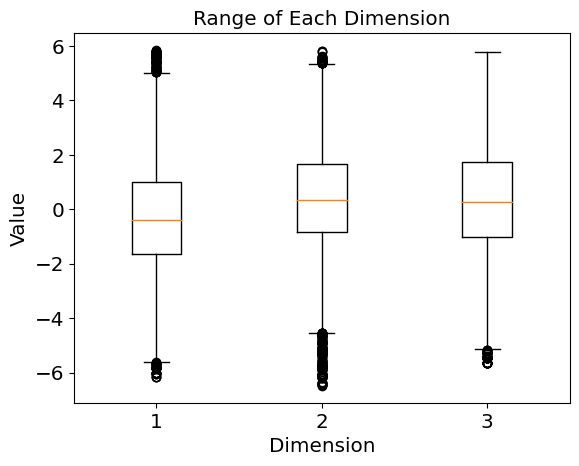

In [11]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pickle
import torch
import pandas
from VAE_model import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sys import exit
from torch.utils.data import Dataset, DataLoader

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')


# Data path
training_data = "training_data/20231008"

# Model path
model = "training_20240306_211407"

# Read data
with open("./{}/seq_msa_binary.pkl".format(training_data), 'rb') as file_handle:
    seq_msa_binary = pickle.load(file_handle)    
num_seq = seq_msa_binary.shape[0]
len_protein = seq_msa_binary.shape[1]
num_res_type = seq_msa_binary.shape[2]
seq_msa_binary = seq_msa_binary.reshape((num_seq, -1))
seq_msa_binary = seq_msa_binary.astype(np.float32)

with open("./{}/seq_weight.pkl".format(training_data), 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)

with open("./{}/keys_list.pkl".format(training_data), 'rb') as file_handle:
    seq_keys = pickle.load(file_handle)

batch_size = num_seq
data = MSA_Dataset(seq_msa_binary, seq_weight, seq_keys)
dataloader = DataLoader(data, batch_size = batch_size)
vae = VAE(num_aa_type = 21,
          dim_latent_vars = 3,
          dim_msa_vars = len_protein*num_res_type,
          encoder_num_hidden_units = [500, 100], 
          decoder_num_hidden_units = [100, 500])
# vae.cuda()
vae.load_state_dict(torch.load("./model/{}/vae_fold_4.model".format(model)))

# Transform the data to mu
mu_list = []
sigma_list = []
key_list = []
for idx, data in enumerate(dataloader):
    msa, weight, key = data
    with torch.no_grad():
        mu, sigma = vae.encoder(msa)
        # gpu to cpu to numpy
        mu_list.append(mu.cpu().data.numpy())
        sigma_list.append(sigma.cpu().data.numpy())
        # key is a tuple
        key_list = key_list + list(key)

mu = np.vstack(mu_list)
sigma = np.vstack(sigma_list)

with open("./model/{}/latent_space.pkl".format(model), 'wb') as file_handle:
    pickle.dump({'key': key_list, 'mu': mu, 'sigma': sigma}, file_handle) 

# Create a box plot
plt.boxplot(mu)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Range of Each Dimension')
plt.show()

#### 5-dimensional latent space:

* Training run at 20240311_144749
* epochs: 1000
* weight_decay: 3.099359450004975e-05
* batch_size: 128
* learning_rate: 0.0010933900752510975
* dim: 5
* encode_layer: [500, 100]
* decode_layer: [100, 500]
* seed: 2
* input_file_folder: ./training_data/20231008

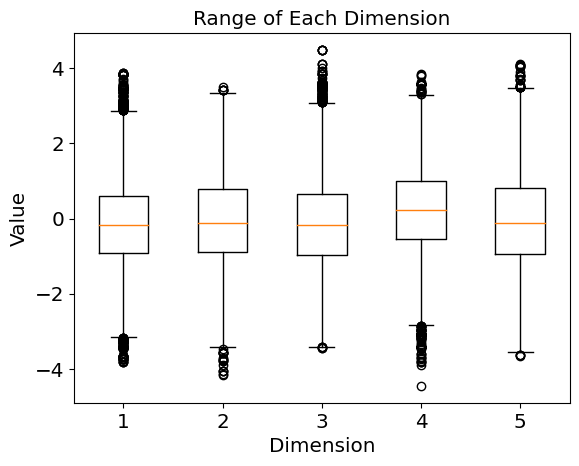

In [2]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pickle
import torch
import pandas
from VAE_model import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sys import exit
from torch.utils.data import Dataset, DataLoader

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')


# Data path
training_data = "training_data/20231008"

# Model path
model = "training_20240311_144749"

# Read data
with open("./{}/seq_msa_binary.pkl".format(training_data), 'rb') as file_handle:
    seq_msa_binary = pickle.load(file_handle)    
num_seq = seq_msa_binary.shape[0]
len_protein = seq_msa_binary.shape[1]
num_res_type = seq_msa_binary.shape[2]
seq_msa_binary = seq_msa_binary.reshape((num_seq, -1))
seq_msa_binary = seq_msa_binary.astype(np.float32)

with open("./{}/seq_weight.pkl".format(training_data), 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)

with open("./{}/keys_list.pkl".format(training_data), 'rb') as file_handle:
    seq_keys = pickle.load(file_handle)

batch_size = num_seq
data = MSA_Dataset(seq_msa_binary, seq_weight, seq_keys)
dataloader = DataLoader(data, batch_size = batch_size)
vae = VAE(num_aa_type = 21,
          dim_latent_vars = 5,
          dim_msa_vars = len_protein*num_res_type,
          encoder_num_hidden_units = [500, 100], 
          decoder_num_hidden_units = [100, 500])
# vae.cuda()
vae.load_state_dict(torch.load("./model/{}/vae_fold_0.model".format(model)))

# Transform the data to mu
mu_list = []
sigma_list = []
key_list = []
for idx, data in enumerate(dataloader):
    msa, weight, key = data
    with torch.no_grad():
        mu, sigma = vae.encoder(msa)
        # gpu to cpu to numpy
        mu_list.append(mu.cpu().data.numpy())
        sigma_list.append(sigma.cpu().data.numpy())
        # key is a tuple
        key_list = key_list + list(key)

mu = np.vstack(mu_list)
sigma = np.vstack(sigma_list)

with open("./model/{}/latent_space.pkl".format(model), 'wb') as file_handle:
    pickle.dump({'key': key_list, 'mu': mu, 'sigma': sigma}, file_handle) 

# Create a box plot
plt.boxplot(mu)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Range of Each Dimension')
plt.show()

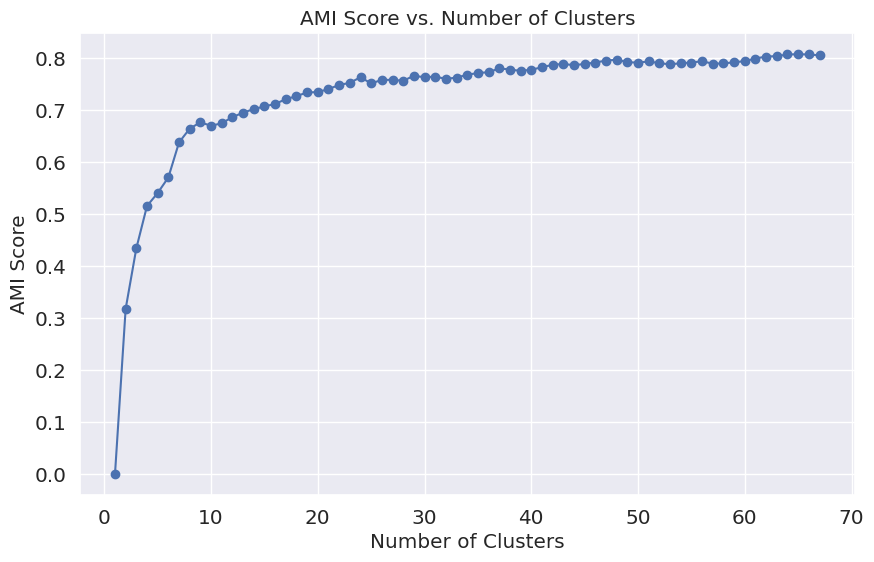

Highest AMI score:  0.8080531527885993


In [3]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns; sns.set()
from Bio import SeqIO
from VAE_model import *
from sys import exit
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')

# Read latent space representation
model = "training_20240311_144749" # model directory
with open("./model/{}/latent_space.pkl".format(model), 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
key2mu = {k[0:14]: m for k, m in zip(key, mu)}

# Read ssn
def ssn_analyzer(file):
    
    df = pd.read_excel(file)
    # id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    id_list = df['Description'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Node Count Cluster Number']
    id_to_cluster_dict = {id: cluster_no for id, cluster_no in zip(id_list, cluster_list)}

    return id_to_cluster_dict

# ssn_file = "/home/cdchiang/vae/RiPPs/data/ssn/class_I-precursors_peptide_all_AS20_node_sorted_2ndfiltered.xlsx"
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_c_u_AS14 Full Network colorized default node_sorted_unique.xlsx"
id_to_cluster_dict = ssn_analyzer(ssn_file)

# Retrieve mu values corresponding to the IDs in id_to_cluster_dict
mu_values = [key2mu[id] for id in id_to_cluster_dict.keys() if id in key2mu]
labels_true = [id_to_cluster_dict[id] for id in id_to_cluster_dict.keys() if id in key2mu]

# Convert the list of mu values to a NumPy array
mu_array = np.array(mu_values)

AMI_score = []
unique_clusters = len(set(id_to_cluster_dict.values()))
for n in range(1, unique_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n).fit(mu_array)
    ami = adjusted_mutual_info_score(labels_true, clustering.labels_)
    AMI_score.append(ami)

# Plotting

num_clusters_list = [n for n in range(1, unique_clusters + 1)]

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_list, AMI_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('AMI Score')
plt.title('AMI Score vs. Number of Clusters')
plt.grid(True)
plt.show()
print('Highest AMI score: ', max(AMI_score))

#### Clustering agreement between (1) the clustering of RiPPs peptide precursors by SSN and (2) the clustering of LanC-like cyclases in the 3D latent space trained by a VAE

* Date: 03/06/2024

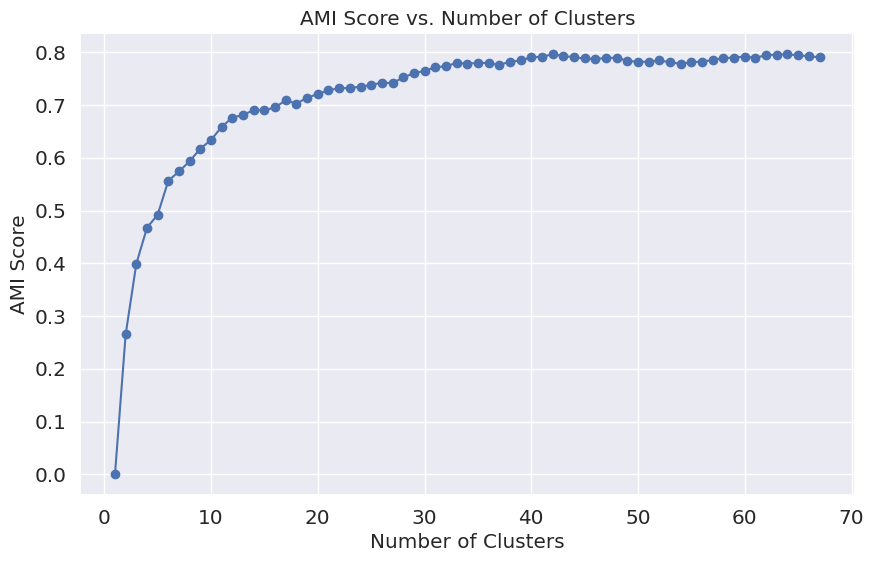

Highest AMI score:  0.7966190680248256


In [19]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns; sns.set()
from Bio import SeqIO
from VAE_model import *
from sys import exit
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')

# Read latent space representation
model = "training_20240306_211407" # model directory
with open("./model/{}/latent_space.pkl".format(model), 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
key2mu = {k[0:14]: m for k, m in zip(key, mu)}

# Read ssn
def ssn_analyzer(file):
    
    df = pd.read_excel(file)
    # id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    id_list = df['Description'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Node Count Cluster Number']
    id_to_cluster_dict = {id: cluster_no for id, cluster_no in zip(id_list, cluster_list)}

    return id_to_cluster_dict

# ssn_file = "/home/cdchiang/vae/RiPPs/data/ssn/class_I-precursors_peptide_all_AS20_node_sorted_2ndfiltered.xlsx"
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_c_u_AS14 Full Network colorized default node_sorted_unique.xlsx"
id_to_cluster_dict = ssn_analyzer(ssn_file)

# Retrieve mu values corresponding to the IDs in id_to_cluster_dict
mu_values = [key2mu[id] for id in id_to_cluster_dict.keys() if id in key2mu]
labels_true = [id_to_cluster_dict[id] for id in id_to_cluster_dict.keys() if id in key2mu]

# Convert the list of mu values to a NumPy array
mu_array = np.array(mu_values)

AMI_score = []
unique_clusters = len(set(id_to_cluster_dict.values()))
for n in range(1, unique_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n).fit(mu_array)
    ami = adjusted_mutual_info_score(labels_true, clustering.labels_)
    AMI_score.append(ami)

# Plotting

num_clusters_list = [n for n in range(1, unique_clusters + 1)]

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_list, AMI_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('AMI Score')
plt.title('AMI Score vs. Number of Clusters')
plt.grid(True)
plt.show()
print('Highest AMI score: ', max(AMI_score))

#### 10-dimensional latent space
* Training run at 20240306_211653
* epochs: 1000
* weight_decay: 1.9331170554982292e-05
* batch_size: 128
* learning_rate: 0.0013580567663540545
* dim: 10
* encode_layer: [500, 100]
* decode_layer: [100, 500]
* seed: 2
* input_file_folder: ./training_data/20231008

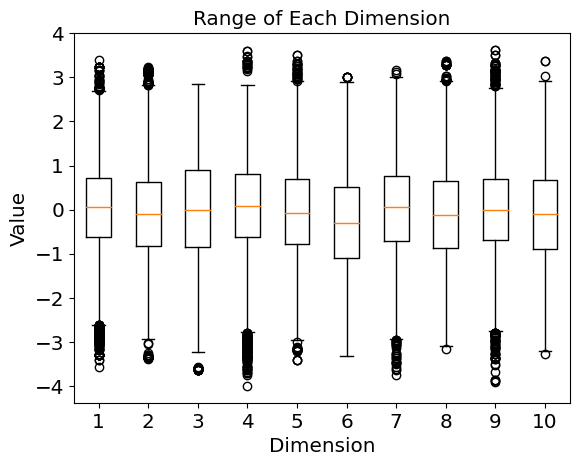

In [1]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pickle
import torch
import pandas
from VAE_model import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sys import exit
from torch.utils.data import Dataset, DataLoader

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')


# Data path
training_data = "training_data/20231008"

# Model path
model = "training_20240306_211653"

# Read data
with open("./{}/seq_msa_binary.pkl".format(training_data), 'rb') as file_handle:
    seq_msa_binary = pickle.load(file_handle)    
num_seq = seq_msa_binary.shape[0]
len_protein = seq_msa_binary.shape[1]
num_res_type = seq_msa_binary.shape[2]
seq_msa_binary = seq_msa_binary.reshape((num_seq, -1))
seq_msa_binary = seq_msa_binary.astype(np.float32)

with open("./{}/seq_weight.pkl".format(training_data), 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)

with open("./{}/keys_list.pkl".format(training_data), 'rb') as file_handle:
    seq_keys = pickle.load(file_handle)

batch_size = num_seq
data = MSA_Dataset(seq_msa_binary, seq_weight, seq_keys)
dataloader = DataLoader(data, batch_size = batch_size)
vae = VAE(num_aa_type = 21,
          dim_latent_vars = 10,
          dim_msa_vars = len_protein*num_res_type,
          encoder_num_hidden_units = [500, 100], 
          decoder_num_hidden_units = [100, 500])
# vae.cuda()
vae.load_state_dict(torch.load("./model/{}/vae_fold_0.model".format(model)))

# Transform the data to mu
mu_list = []
sigma_list = []
key_list = []
for idx, data in enumerate(dataloader):
    msa, weight, key = data
    with torch.no_grad():
        mu, sigma = vae.encoder(msa)
        # gpu to cpu to numpy
        mu_list.append(mu.cpu().data.numpy())
        sigma_list.append(sigma.cpu().data.numpy())
        # key is a tuple
        key_list = key_list + list(key)

mu = np.vstack(mu_list)
sigma = np.vstack(sigma_list)

with open("./model/{}/latent_space.pkl".format(model), 'wb') as file_handle:
    pickle.dump({'key': key_list, 'mu': mu, 'sigma': sigma}, file_handle)

# Create a box plot
plt.boxplot(mu)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Range of Each Dimension')
plt.show()

#### Clustering agreement between (1) the clustering of RiPPs peptide precursors by SSN and (2) the clustering of LanC-like cyclases in the 10D latent space trained by a VAE

* Date: 03/06/2024

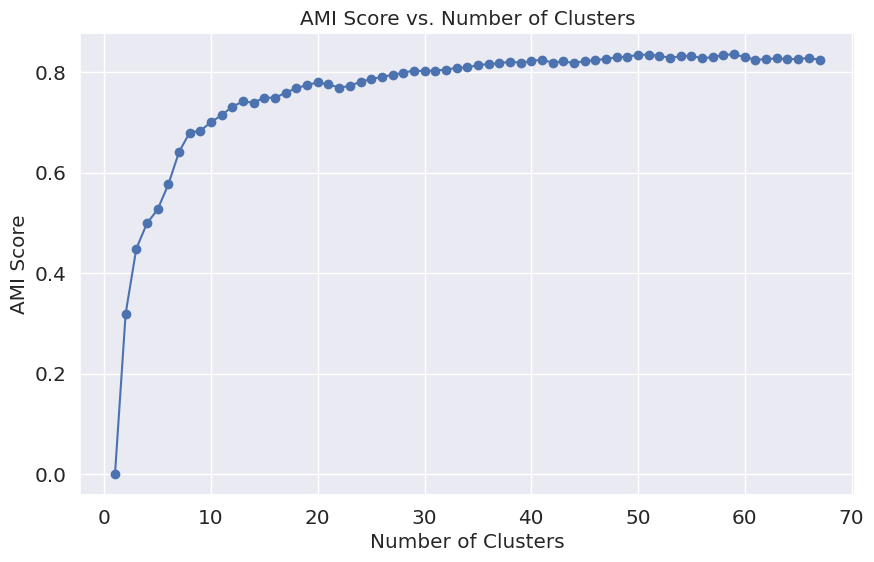

Highest AMI score:  0.8356143947254066


In [20]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns; sns.set()
from Bio import SeqIO
from VAE_model import *
from sys import exit
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')

# Read latent space representation
model = "training_20240306_211653" # model directory
with open("./model/{}/latent_space.pkl".format(model), 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
key2mu = {k[0:14]: m for k, m in zip(key, mu)}

# Read ssn
def ssn_analyzer(file):
    
    df = pd.read_excel(file)
    # id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    id_list = df['Description'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Node Count Cluster Number']
    id_to_cluster_dict = {id: cluster_no for id, cluster_no in zip(id_list, cluster_list)}

    return id_to_cluster_dict

# ssn_file = "/home/cdchiang/vae/RiPPs/data/ssn/class_I-precursors_peptide_all_AS20_node_sorted_2ndfiltered.xlsx"
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_c_u_AS14 Full Network colorized default node_sorted_unique.xlsx"
id_to_cluster_dict = ssn_analyzer(ssn_file)

# Retrieve mu values corresponding to the IDs in id_to_cluster_dict
mu_values = [key2mu[id] for id in id_to_cluster_dict.keys() if id in key2mu]
labels_true = [id_to_cluster_dict[id] for id in id_to_cluster_dict.keys() if id in key2mu]

# Convert the list of mu values to a NumPy array
mu_array = np.array(mu_values)

AMI_score = []
unique_clusters = len(set(id_to_cluster_dict.values()))
for n in range(1, unique_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n).fit(mu_array)
    ami = adjusted_mutual_info_score(labels_true, clustering.labels_)
    AMI_score.append(ami)

# Plotting

num_clusters_list = [n for n in range(1, unique_clusters + 1)]

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_list, AMI_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('AMI Score')
plt.title('AMI Score vs. Number of Clusters')
plt.grid(True)
plt.show()
print('Highest AMI score: ', max(AMI_score))

#### Clustering agreement between (1) the clustering of RiPPs peptide precursors by SSN and (2) the clustering of LanC-like cyclases in the 15D latent space trained by a VAE

* Date: 03/08/2024

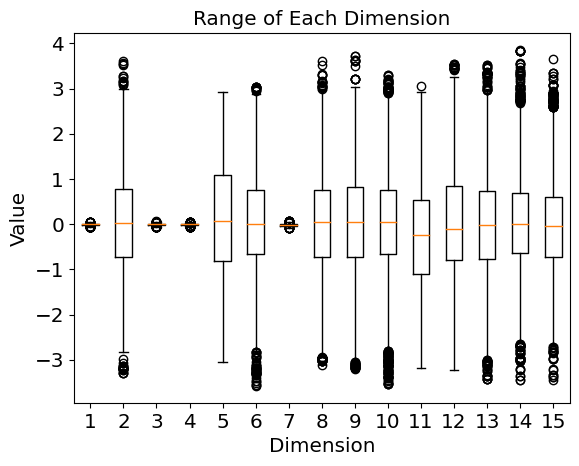

In [1]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pickle
import torch
import pandas
from VAE_model import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sys import exit
from torch.utils.data import Dataset, DataLoader

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')


# Data path
training_data = "training_data/20231008"

# Model path
model = "training_20240308_110830"

# Read data
with open("./{}/seq_msa_binary.pkl".format(training_data), 'rb') as file_handle:
    seq_msa_binary = pickle.load(file_handle)    
num_seq = seq_msa_binary.shape[0]
len_protein = seq_msa_binary.shape[1]
num_res_type = seq_msa_binary.shape[2]
seq_msa_binary = seq_msa_binary.reshape((num_seq, -1))
seq_msa_binary = seq_msa_binary.astype(np.float32)

with open("./{}/seq_weight.pkl".format(training_data), 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)

with open("./{}/keys_list.pkl".format(training_data), 'rb') as file_handle:
    seq_keys = pickle.load(file_handle)

batch_size = num_seq
data = MSA_Dataset(seq_msa_binary, seq_weight, seq_keys)
dataloader = DataLoader(data, batch_size = batch_size)
vae = VAE(num_aa_type = 21,
          dim_latent_vars = 15,
          dim_msa_vars = len_protein*num_res_type,
          encoder_num_hidden_units = [500, 100], 
          decoder_num_hidden_units = [100, 500])
# vae.cuda()
vae.load_state_dict(torch.load("./model/{}/vae_fold_0.model".format(model)))

# Transform the data to mu
mu_list = []
sigma_list = []
key_list = []
for idx, data in enumerate(dataloader):
    msa, weight, key = data
    with torch.no_grad():
        mu, sigma = vae.encoder(msa)
        # gpu to cpu to numpy
        mu_list.append(mu.cpu().data.numpy())
        sigma_list.append(sigma.cpu().data.numpy())
        # key is a tuple
        key_list = key_list + list(key)

mu = np.vstack(mu_list)
sigma = np.vstack(sigma_list)

with open("./model/{}/latent_space.pkl".format(model), 'wb') as file_handle:
    pickle.dump({'key': key_list, 'mu': mu, 'sigma': sigma}, file_handle)

# Create a box plot
plt.boxplot(mu)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Range of Each Dimension')
plt.show()

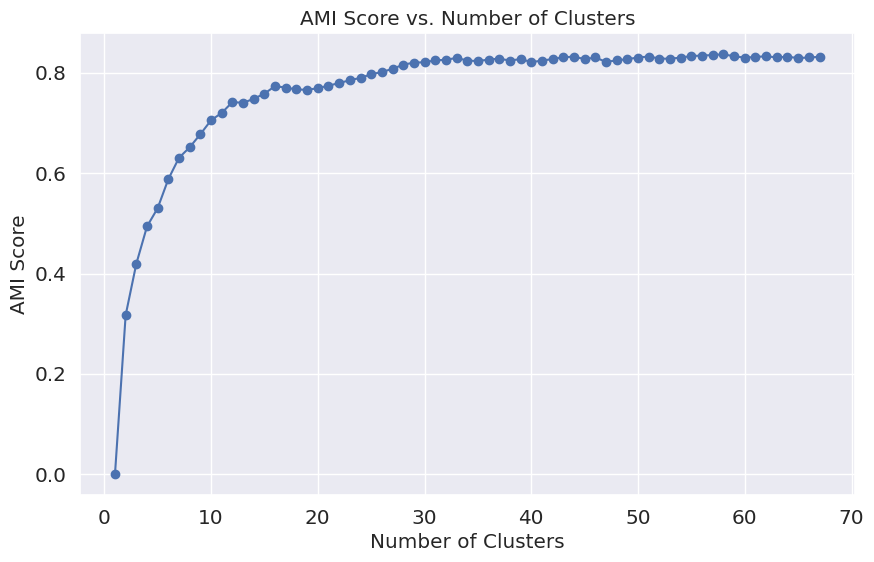

Highest AMI score:  0.8370096474572031


In [2]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns; sns.set()
from Bio import SeqIO
from VAE_model import *
from sys import exit
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')

# Read latent space representation
model = "training_20240308_110830" # model directory
with open("./model/{}/latent_space.pkl".format(model), 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
key2mu = {k[0:14]: m for k, m in zip(key, mu)}

# Read ssn
def ssn_analyzer(file):
    
    df = pd.read_excel(file)
    # id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    id_list = df['Description'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Node Count Cluster Number']
    id_to_cluster_dict = {id: cluster_no for id, cluster_no in zip(id_list, cluster_list)}

    return id_to_cluster_dict

# ssn_file = "/home/cdchiang/vae/RiPPs/data/ssn/class_I-precursors_peptide_all_AS20_node_sorted_2ndfiltered.xlsx"
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_c_u_AS14 Full Network colorized default node_sorted_unique.xlsx"
id_to_cluster_dict = ssn_analyzer(ssn_file)

# Retrieve mu values corresponding to the IDs in id_to_cluster_dict
mu_values = [key2mu[id] for id in id_to_cluster_dict.keys() if id in key2mu]
labels_true = [id_to_cluster_dict[id] for id in id_to_cluster_dict.keys() if id in key2mu]

# Convert the list of mu values to a NumPy array
mu_array = np.array(mu_values)

AMI_score = []
unique_clusters = len(set(id_to_cluster_dict.values()))
for n in range(1, unique_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n).fit(mu_array)
    ami = adjusted_mutual_info_score(labels_true, clustering.labels_)
    AMI_score.append(ami)

# Plotting

num_clusters_list = [n for n in range(1, unique_clusters + 1)]

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_list, AMI_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('AMI Score')
plt.title('AMI Score vs. Number of Clusters')
plt.grid(True)
plt.show()
print('Highest AMI score: ', max(AMI_score))

#### Clustering agreement between (1) the clustering of RiPPs peptide precursors by SSN and (2) the clustering of LanC-like cyclases in the 20D latent space trained by a VAE

* Date: 03/08/2024

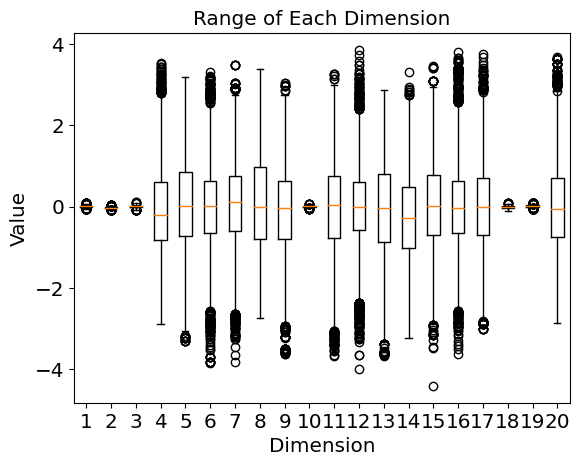

In [1]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pickle
import torch
import pandas
from VAE_model import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sys import exit
from torch.utils.data import Dataset, DataLoader

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')


# Data path
training_data = "training_data/20231008"

# Model path
model = "training_20240308_111156"

# Read data
with open("./{}/seq_msa_binary.pkl".format(training_data), 'rb') as file_handle:
    seq_msa_binary = pickle.load(file_handle)    
num_seq = seq_msa_binary.shape[0]
len_protein = seq_msa_binary.shape[1]
num_res_type = seq_msa_binary.shape[2]
seq_msa_binary = seq_msa_binary.reshape((num_seq, -1))
seq_msa_binary = seq_msa_binary.astype(np.float32)

with open("./{}/seq_weight.pkl".format(training_data), 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)

with open("./{}/keys_list.pkl".format(training_data), 'rb') as file_handle:
    seq_keys = pickle.load(file_handle)

batch_size = num_seq
data = MSA_Dataset(seq_msa_binary, seq_weight, seq_keys)
dataloader = DataLoader(data, batch_size = batch_size)
vae = VAE(num_aa_type = 21,
          dim_latent_vars = 20,
          dim_msa_vars = len_protein*num_res_type,
          encoder_num_hidden_units = [500, 100], 
          decoder_num_hidden_units = [100, 500])
# vae.cuda()
vae.load_state_dict(torch.load("./model/{}/vae_fold_2.model".format(model)))

# Transform the data to mu
mu_list = []
sigma_list = []
key_list = []
for idx, data in enumerate(dataloader):
    msa, weight, key = data
    with torch.no_grad():
        mu, sigma = vae.encoder(msa)
        # gpu to cpu to numpy
        mu_list.append(mu.cpu().data.numpy())
        sigma_list.append(sigma.cpu().data.numpy())
        # key is a tuple
        key_list = key_list + list(key)

mu = np.vstack(mu_list)
sigma = np.vstack(sigma_list)

with open("./model/{}/latent_space.pkl".format(model), 'wb') as file_handle:
    pickle.dump({'key': key_list, 'mu': mu, 'sigma': sigma}, file_handle)

# Create a box plot
plt.boxplot(mu)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.title('Range of Each Dimension')
plt.show()

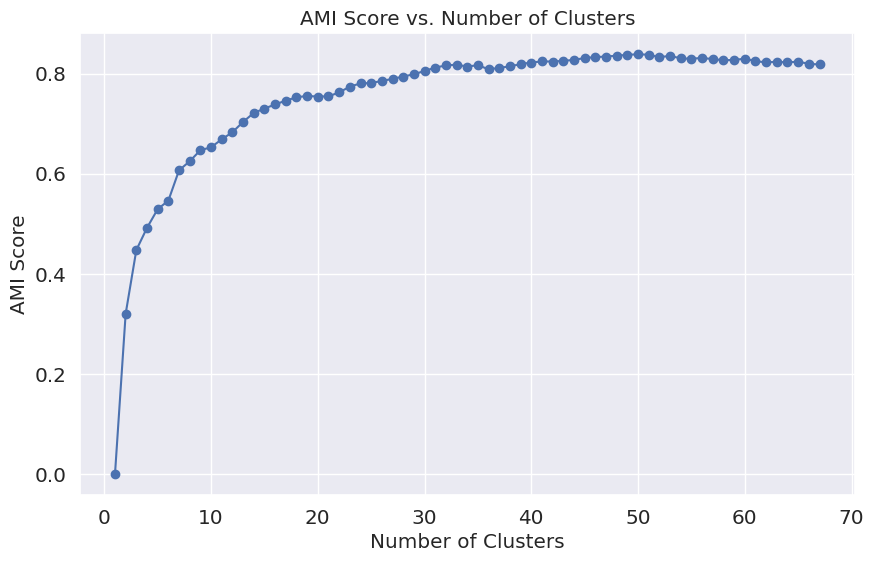

Highest AMI score:  0.8389100512235916


In [4]:
import matplotlib as mpl
# non-iteractive but high-quality image files
# mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns; sns.set()
from Bio import SeqIO
from VAE_model import *
from sys import exit
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

# Make the format of images consistent
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 'large', labelsize = 'large')
mpl.rc('xtick', labelsize = 'large')
mpl.rc('ytick', labelsize = 'large')

# Read latent space representation
model = "training_20240308_111156" # model directory
with open("./model/{}/latent_space.pkl".format(model), 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
key2mu = {k[0:14]: m for k, m in zip(key, mu)}

# Read ssn
def ssn_analyzer(file):
    
    df = pd.read_excel(file)
    # id_list = df['name'].apply(lambda x: x[0:14]).tolist()
    id_list = df['Description'].apply(lambda x: x[0:14]).tolist()
    cluster_list = df['Node Count Cluster Number']
    id_to_cluster_dict = {id: cluster_no for id, cluster_no in zip(id_list, cluster_list)}

    return id_to_cluster_dict

# ssn_file = "/home/cdchiang/vae/RiPPs/data/ssn/class_I-precursors_peptide_all_AS20_node_sorted_2ndfiltered.xlsx"
ssn_file = "../data/ssn/csv_file/class_I-precursors_peptide_c_u_AS14 Full Network colorized default node_sorted_unique.xlsx"
id_to_cluster_dict = ssn_analyzer(ssn_file)

# Retrieve mu values corresponding to the IDs in id_to_cluster_dict
mu_values = [key2mu[id] for id in id_to_cluster_dict.keys() if id in key2mu]
labels_true = [id_to_cluster_dict[id] for id in id_to_cluster_dict.keys() if id in key2mu]

# Convert the list of mu values to a NumPy array
mu_array = np.array(mu_values)

AMI_score = []
unique_clusters = len(set(id_to_cluster_dict.values()))
for n in range(1, unique_clusters + 1):
    clustering = AgglomerativeClustering(n_clusters=n).fit(mu_array)
    ami = adjusted_mutual_info_score(labels_true, clustering.labels_)
    AMI_score.append(ami)

# Plotting

num_clusters_list = [n for n in range(1, unique_clusters + 1)]

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_list, AMI_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('AMI Score')
plt.title('AMI Score vs. Number of Clusters')
plt.grid(True)
plt.show()
print('Highest AMI score: ', max(AMI_score))

#### Lowercase to uppercase

In [1]:
from Bio import SeqIO

def convert_fasta_to_uppercase(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for record in SeqIO.parse(infile, 'fasta'):
            record.seq = record.seq.upper()
            SeqIO.write(record, outfile, 'fasta')

# Example usage
input_fasta = '/home/cdchiang/esm/examples/data/PF05147_hits_200_500aa.fasta'
output_fasta = '/home/cdchiang/esm/examples/data/PF05147_hits_200_500aa_U.fasta'
convert_fasta_to_uppercase(input_fasta, output_fasta)


#### Extract all sequences in the latent space into a fasta file

In [2]:
import pickle
from Bio import SeqIO

# Load the key list from the .pkl file
with open('/home/cdchiang/vae/RiPPs/vae/training_data/20231008/keys_list.pkl', 'rb') as f:
    key_list = pickle.load(f)
print(key_list)
# Load the sequences from the FASTA file and filter them
fasta_file = '/home/cdchiang/vae/RiPPs/data/PF05147_hits_200_500aa.fasta'
filtered_sequences = []

for record in SeqIO.parse(fasta_file, 'fasta'):
    if record.id in key_list:
        record.description = ''
        filtered_sequences.append(record)

# Save the filtered sequences to a new FASTA file
with open('/home/cdchiang/vae/RiPPs/data/PF05147_hits_200_500aa_latentspace.fasta', 'w') as output_handle:
    SeqIO.write(filtered_sequences, output_handle, 'fasta')







['WP_010896633.1/698-1042', 'WP_053432182.1/698-1042', 'WP_175414292.1/698-1042', 'WP_042635635.1/709-1052', 'WP_227051198.1/709-1052', 'WP_167340942.1/709-1052', 'WP_088461897.1/709-1052', 'WP_202729353.1/709-1052', 'WP_014419285.1/709-1052', 'WP_029325770.1/709-1052', 'WP_165409180.1/709-1052', 'WP_280156830.1/709-1052', 'WP_058906458.1/709-1052', 'WP_115996965.1/709-1052', 'WP_264254727.1/709-1052', 'WP_172615095.1/709-1052', 'WP_146283922.1/709-1052', 'WP_232213059.1/709-1052', 'WP_121591322.1/709-1052', 'WP_196616170.1/709-1052', 'WP_267543444.1/709-1052', 'WP_072176807.1/709-1052', 'WP_202735183.1/709-1052', 'WP_077723066.1/709-1052', 'WP_144464740.1/709-1050', 'WP_268851833.1/39-427', 'WP_014194793.1/39-427', 'WP_223827881.1/712-1055', 'WP_011229813.1/39-426', 'WP_071584286.1/401-747', 'WP_268389175.1/618-964', 'WP_003186383.1/683-1029', 'WP_274685120.1/683-1029', 'WP_016886313.1/683-1029', 'WP_146910800.1/683-1029', 'WP_044821569.1/683-1029', 'WP_069500849.1/683-1029', 'WP_0799